<a href="https://colab.research.google.com/github/varisvithitpaiboon/Proactive-Customer-Experience-Management-Using-Predictive-Analytics-on-WiFi-Behavior-Data/blob/main/UCL_Lifemote_Predictive_Call_Anomaly_Feature_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
!pip -q install optuna
!pip -q install catboost
!pip -q install tsfresh[dask]

In [ ]:
import numpy as np
import pandas as pd
import os
from datetime import timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, average_precision_score
from sklearn.model_selection import cross_val_score
import optuna
import shap
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import IPython.display as display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import gc
import tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import average_precision_score, ndcg_score
import stumpy
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedShuffleSplit
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from tsfresh.feature_selection.relevance import calculate_relevance_table
from xgboost import XGBClassifier
import shap
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from IPython.display import display

# Import data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Network Data

In [ ]:
# Set your folder path inside Google Drive
network_folder_path = '/content/drive/MyDrive/UCL-Lifemote/network_data'
chunksize = 50000  # Adjust based on available RAM

# List all CSV files in the folder
network_csv_files = [f for f in os.listdir(network_folder_path) if f.endswith('.csv')]

# Initialize an empty list to collect all chunks
dataframes = []

# Process files in chunks
for file in tqdm(network_csv_files, desc="Processing CSV files"):
    full_path = os.path.join(network_folder_path, file)
    try:
        chunk_iter = pd.read_csv(full_path, chunksize=chunksize)
        for i, chunk in enumerate(chunk_iter):
            chunk['source_file'] = file  # Optional: tag origin
            chunk['chunk_number'] = i    # Optional: track chunk
            dataframes.append(chunk)     # Store each chunk temporarily
    except Exception as e:
        print(f" Failed to load {file}: {e}")

# Combine all chunks into one DataFrame
if dataframes:
    df_network = pd.concat(dataframes, ignore_index=True)
    print(f" Final df_network shape: {df_network.shape}")
else:
    print(" No valid data was read from the folder.")


Processing CSV files: 100%|██████████| 30/30 [01:40<00:00,  3.34s/it]


 Final df_network shape: (13605240, 96)


In [ ]:
print(df_network['analysis_date'].value_counts(dropna=False))

analysis_date
2025-07-10 00:00:00    458053
2025-07-09 00:00:00    457649
2025-07-07 00:00:00    456972
2025-07-08 00:00:00    456894
2025-07-04 00:00:00    456205
2025-07-06 00:00:00    456075
2025-07-05 00:00:00    456067
2025-07-03 00:00:00    455628
2025-07-02 00:00:00    455247
2025-07-01 00:00:00    455055
2025-06-30 00:00:00    454728
2025-06-27 00:00:00    454109
2025-06-28 00:00:00    453884
2025-06-26 00:00:00    453863
2025-06-29 00:00:00    453761
2025-06-25 00:00:00    452783
2025-06-24 00:00:00    452671
2025-06-23 00:00:00    452463
2025-06-20 00:00:00    451960
2025-06-18 00:00:00    451788
2025-06-19 00:00:00    451544
2025-06-21 00:00:00    451520
2025-06-22 00:00:00    451493
2025-06-17 00:00:00    451360
2025-06-16 00:00:00    451254
2025-06-13 00:00:00    450820
2025-06-14 00:00:00    450519
2025-06-12 00:00:00    450424
2025-06-15 00:00:00    450410
2025-06-11 00:00:00    450041
Name: count, dtype: int64


In [ ]:
df_network.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,mid_fwa_count,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number
0,DEVICE_ID_961c5550db,2025-06-11 00:00:00,ID_b0a43c9bc9,ANALYSIS_ID_e1e909f586,0,0,0,1878,2174,1853,...,0,14,1,0.0,0.0,NaN,41.55,0,cpe_status_2025-06-11_ready.csv,0
1,DEVICE_ID_39190265c2,2025-06-11 00:00:00,ID_5c687e45be,ANALYSIS_ID_05f8ccfe3e,0,0,0,2,2496,1,...,0,0,0,0.0,0.0,NaN,58.12,0,cpe_status_2025-06-11_ready.csv,0
2,DEVICE_ID_77a16a8d79,2025-06-11 00:00:00,ID_11db07b498,ANALYSIS_ID_8df4ed77df,0,0,0,0,818,0,...,0,0,0,0.0,0.0,NaN,39.60,0,cpe_status_2025-06-11_ready.csv,0
3,DEVICE_ID_905832b06c,2025-06-11 00:00:00,ID_393c580a22,ANALYSIS_ID_8ed247d1a2,0,0,0,1634,3787,1625,...,0,4,0,0.0,0.0,NaN,40.48,0,cpe_status_2025-06-11_ready.csv,0
4,DEVICE_ID_8f1dbe5a7f,2025-06-11 00:00:00,ID_67ec92db86,ANALYSIS_ID_55850a81fe,0,0,0,1488,1142,6,...,0,0,0,0.0,0.0,NaN,58.62,0,cpe_status_2025-06-11_ready.csv,0


## Import Call Data

In [ ]:
# Set your folder path inside Google Drive
call_file_path = '/content/drive/MyDrive/UCL-Lifemote/call_data/df_call_final.csv'

# Read the CSV file
df_call = pd.read_csv(call_file_path)

# Preview
print(f"df_call shape: {df_call.shape}")

df_call shape: (47355, 7)


In [ ]:
df_call.head()

,id,resource_id,created_at,user_id,group_name,username,resource
0,1094528,RESOURCE_ID_b1a07b8694,2025-06-11 02:34:53.355349,465,first-line,USERNAME_7cd244d515,home
1,1094529,RESOURCE_ID_072bdfd2f5,2025-06-11 02:34:54.344923,465,first-line,USERNAME_7cd244d515,cpe
2,1094530,RESOURCE_ID_aa2d955d4e,2025-06-11 02:34:54.400746,465,first-line,USERNAME_7cd244d515,cpe
3,1094531,RESOURCE_ID_b1a07b8694,2025-06-11 02:34:54.455219,465,first-line,USERNAME_7cd244d515,cpe
4,1094532,RESOURCE_ID_24e3e9b021,2025-06-11 02:34:54.726571,465,first-line,USERNAME_7cd244d515,cpe


# Data Preprocessing

## Label flag_call and ensure datetime format

In [ ]:
# Flag Call = 1
df_call["flag_call"] = 1

In [ ]:
# Ensure 'analysis_date' is in datetime format
df_network['analysis_date'] = pd.to_datetime(df_network['analysis_date']).dt.normalize()

# Ensure 'created_at' is in datetime format
df_call['created_at'] = pd.to_datetime(df_call['created_at']).dt.normalize()

# Preview values and types
print(df_network['analysis_date'].head())
print(df_call['created_at'].head())

0   2025-06-11
1   2025-06-11
2   2025-06-11
3   2025-06-11
4   2025-06-11
Name: analysis_date, dtype: datetime64[ns]
0   2025-06-11
1   2025-06-11
2   2025-06-11
3   2025-06-11
4   2025-06-11
Name: created_at, dtype: datetime64[ns]


## Extract device_id

In [ ]:
# Extract resource_id
df_call['resource_id'] = df_call['resource_id'].str[12:]
df_call['resource_id'].head(5)

# Count unique customer of df_call
print(f"Number of customers in df_call: {df_call['resource_id'].nunique()}")

Number of customers in df_call: 13401


In [ ]:
# Extract device_id
df_network['device_id'] = df_network['device_id'].str[10:]
df_network['device_id'].head(1)

# count unique customer of df_network
print(f"Number of customers in df_network {df_network['device_id'].nunique()}")

Number of customers in df_network 475660


## Drop duplicate calls

In [ ]:
# Drop duplicate call on the same day
df_call = df_call.drop_duplicates(subset=['resource_id', 'created_at'], keep='first')
# df_call.head()
df_call.shape

(14924, 8)

In [ ]:
# Count how many customer_ids appear in both DataFrames
overlap_count = len(set(df_network['device_id']) & set(df_call['resource_id']))
print(f"Overlapping device_id & resource_id count: {overlap_count}")

Overlapping device_id & resource_id count: 12869


## Merge df_network and df_call

In [ ]:
# Merge df_network and df_call
def memory_efficient_merge(df_network, df_call, chunk_size=50_000):
    # Optimize data types before merging
    df_network['device_id'] = df_network['device_id'].astype('category')
    df_call['resource_id'] = df_call['resource_id'].astype('category')

    # Downcast numeric columns in df_call
    df_call['flag_call'] = pd.to_numeric(df_call['flag_call'], downcast='integer')

    # Convert string columns to category if they have low cardinality
    for col in ['group_name', 'resource']:
        if df_call[col].nunique() / len(df_call[col]) < 0.5:
            df_call[col] = df_call[col].astype('category')

    # Prepare the right dataframe columns to merge
    merge_cols = ['resource_id', 'group_name', 'resource', 'created_at', 'flag_call']
    df_call_reduced = df_call[merge_cols].copy()

    # Process in chunks
    chunks = []
    for i in range(0, len(df_network), chunk_size):
        network_chunk = df_network.iloc[i:i+chunk_size]

        # Merge with optimized memory
        merged_chunk = network_chunk.merge(
            df_call_reduced,
            how='left',
            left_on=['device_id', 'analysis_date'],
            right_on=['resource_id', 'created_at']
        )

        # Optimize the merged chunk
        merged_chunk['flag_call'] = merged_chunk['flag_call'].fillna(0).astype('int8')

        # Append to results and clean up
        chunks.append(merged_chunk)
        del network_chunk, merged_chunk
        gc.collect()

    # Concatenate all chunks
    final_df = pd.concat(chunks, ignore_index=True)

    # Clean up
    del chunks, df_call_reduced
    gc.collect()

    return final_df

df_merged = memory_efficient_merge(df_network, df_call)

In [ ]:
del df_network, df_call

gc.collect()

0

In [ ]:
# Select Sample devices to run the model, whle keeping proportion of fault positive similar to original dataset
def sample_complete_devices(df, target_devices=20_000, fault_col='flag_call', date_col='analysis_date', random_state=42):

    # Calculate original proportions
    original_row_ratio = df[fault_col].mean()
    device_status = df.groupby('device_id')[fault_col].mean().gt(0)
    original_device_ratio = device_status.mean()

    print(f"Original row fault ratio: {original_row_ratio:.5f}")
    print(f"Original device fault ratio: {original_device_ratio:.5f}")

    # Get complete devices (all dates present)
    n_dates = df[date_col].nunique()
    complete_devices = (df.groupby('device_id')[date_col]
                       .nunique()
                       .loc[lambda x: x == n_dates]
                       .index)
    df_complete = df[df['device_id'].isin(complete_devices)]

    # Classify complete devices
    device_status = df_complete.groupby('device_id')[fault_col].mean().gt(0)
    faulty_devices = device_status[device_status].index
    healthy_devices = device_status[~device_status].index

    # Calculate required samples
    n_faulty = int(round(target_devices * original_device_ratio))
    n_faulty = min(n_faulty, len(faulty_devices))
    n_healthy = target_devices - n_faulty

    # Sample devices
    np.random.seed(random_state)
    sampled_faulty = np.random.choice(faulty_devices, n_faulty, replace=False)
    sampled_healthy = np.random.choice(healthy_devices, n_healthy, replace=False)

    # Combine sampled devices
    sampled_devices = np.concatenate([sampled_faulty, sampled_healthy])
    df_sampled = df_complete[df_complete['device_id'].isin(sampled_devices)]  # Consistent naming

    # Calculate scaling factor to match original row ratio
    current_row_ratio = df_sampled[fault_col].mean()
    if current_row_ratio > 0:
        scale_factor = original_row_ratio / current_row_ratio
        if scale_factor < 1:
            # Downsample fault rows
            fault_rows = df_sampled[df_sampled[fault_col] == 1]
            keep_prob = min(scale_factor, 1.0)
            mask = np.random.random(len(fault_rows)) < keep_prob
            df_sampled = pd.concat([
                df_sampled[df_sampled[fault_col] == 0],
                fault_rows[mask]
            ])

    # Verification
    verification = {
        'total_devices': df_sampled['device_id'].nunique(),
        'faulty_devices': len(sampled_faulty),
        'row_fault_ratio': df_sampled[fault_col].mean(),
        'device_fault_ratio': (df_sampled.groupby('device_id')[fault_col].mean() > 0).mean(),
        'date_completeness': (df_sampled.groupby('device_id')[date_col].nunique() == n_dates).all(),
        'total_rows': len(df_sampled)
    }

    print("\n=== Results ===")
    print(f"Sampled devices: {verification['total_devices']}")
    print(f"Faulty devices: {verification['faulty_devices']}")
    print(f"Achieved row fault ratio: {verification['row_fault_ratio']:.5f}")
    print(f"Device fault ratio: {verification['device_fault_ratio']:.5f}")
    print(f"All dates present: {verification['date_completeness']}")
    print(f"Total rows: {verification['total_rows']}")

    return df_sampled

# Usage
df_merged = sample_complete_devices(df_merged)

Original row fault ratio: 0.00074
Original device fault ratio: 0.01865

=== Results ===
Sampled devices: 20000
Faulty devices: 373
Achieved row fault ratio: 0.00071
Device fault ratio: 0.01865
All dates present: True
Total rows: 600000


In [ ]:
# Count positive and negative flag_call values
call_counts = df_merged['flag_call'].value_counts().sort_index()

# Print results
print(" Flag Call Counts:")
print(f"Negative (0): {call_counts.get(0, 0)}")
print(f"Positive (1): {call_counts.get(1, 0)}")

del call_counts

gc.collect()

 Flag Call Counts:
Negative (0): 599572
Positive (1): 428


0

In [ ]:
df_merged.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,resource_id,group_name,resource,created_at,flag_call
13,7f443695a6,2025-06-11,ID_8a2ac2b198,ANALYSIS_ID_31d3810016,0,0,0,3649,2846,3435,...,NaN,40.43,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
31,7d2bbf8463,2025-06-11,ID_ea4f03ae88,ANALYSIS_ID_6a66dea521,0,0,0,2791,2485,1916,...,NaN,48.33,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
55,0081311cd3,2025-06-11,ID_3a9e5432f1,ANALYSIS_ID_eb9f1fd007,0,0,0,4572,2192,1890,...,NaN,59.21,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
67,71518abf57,2025-06-11,ID_5e077d4dff,ANALYSIS_ID_015d1ae49a,0,0,0,676,3908,346,...,NaN,21.38,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
108,1785e6457a,2025-06-11,ID_4972f96173,ANALYSIS_ID_2da83f8d34,1,0,0,2790,3569,1433,...,NaN,47.06,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0


# Data Cleaning

In [ ]:
# Drop rows with missing flag_call
original_len = len(df_merged)

df_merged = df_merged.dropna(subset=['flag_call']).reset_index(drop=True)

print(f"Removed {original_len - len(df_merged)} rows with missing flag_call")

del original_len

gc.collect()

Removed 0 rows with missing flag_call


0

In [ ]:
# Check which columns are completely empty (all values are NaN)
empty_columns = df_merged.columns[df_merged.isnull().all()].tolist()

# Print result
if empty_columns:
    print(f"Number of rows and columns: {df_merged.shape}")
    print(f"Number of empty columns: {len(empty_columns)}")
    print(f"Empty column names: {(empty_columns)}")
else:
    print("No empty columns")

Number of rows and columns: (600000, 101)
Number of empty columns: 11
Empty column names: ['cpu_temp', 'dsl_status', 'greedy_status', 'dsl_connection_stability_status', 'dsl_rate_stability_status', 'congestion_6_status', 'wifi_standard_24', 'wifi_standard_5', 'wifi_standard_6', 'fwa_quality_status', 'channel_changes_count_6']


In [ ]:
del empty_columns

gc.collect()

0

In [ ]:
# Drop NaN columns
df_merged = df_merged.dropna(axis=1, how='all')
print(f"Number of rows and columns: {df_merged.shape}")

Number of rows and columns: (600000, 90)


In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 2 decimal places
filling_rates = filling_rates.round(2)

# Identify columns with < 50% filled
low_fill_columns = filling_rates[filling_rates < 50].index.tolist()

# Drop those columns
df_merged = df_merged.drop(columns=low_fill_columns)

# Print summary
print(f"Dropped {len(low_fill_columns)}")
print(f"low-filling columns (<50% filled): {low_fill_columns}")
print(f"New shape: {df_merged.shape}")

del filling_rates
del low_fill_columns

gc.collect()

Dropped 7
low-filling columns (<50% filled): ['legacy_status', 'repeater_status', 'max_outage_time', 'resource_id', 'group_name', 'resource', 'created_at']
New shape: (600000, 83)


0

In [ ]:
# List of columns to keep even if they have constant values
columns_to_keep = ['analysis_date', 'flag_call']

# Identify constant columns excluding the ones to keep
constant_columns = [
    col for col in df_merged.columns
    if df_merged[col].nunique(dropna=False) == 1 and col not in columns_to_keep
]

# Drop those columns
df_merged = df_merged.drop(columns=constant_columns)

# Print summary
print(f"Dropped {len(constant_columns)}")
print(f"constant columns: {constant_columns}")

del columns_to_keep
del constant_columns

gc.collect()

Dropped 20
constant columns: ['dsl_download_bottleneck_count', 'dsl_upload_bottleneck_count', 'interfered_active_samples_24', 'interfered_samples_24', 'greedy_event_count', 'wifi_bottleneck_count', 'poor_greedy_event_count', 'total_samples_6', 'poor_samples_6', 'mid_samples_6', 'good_samples_6', 'total_active_samples_6', 'poor_active_samples_6', 'mid_active_samples_6', 'good_active_samples_6', 'sample_active_6_count', 'congested_sample_6_count', 'congested_sample_active_6_count', 'poor_fwa_count', 'mid_fwa_count']


0

In [ ]:
# Drop irrelavant columns
irrelevant_columns = ['source_file', 'id', 'analysis_id']

# Drop those columns
df_merged = df_merged.drop(columns=irrelevant_columns)

# Print summary
print(f"Dropped {len(irrelevant_columns)}")
print(f"New shape: {df_merged.shape}")

del irrelevant_columns

gc.collect()

Dropped 3
New shape: (600000, 60)


0

In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 4 decimal places
filling_rates = filling_rates.round(4)

# Filter and sort columns with less than 100% filled
incomplete_columns = filling_rates[filling_rates < 100].sort_values(ascending=False)

# Print the result
if not incomplete_columns.empty:
    print("Columns with less than 100% non-null values (ascending):")
    print(incomplete_columns)
    print(len(incomplete_columns))

    # Calculate and print the number of missing rows for each incomplete column
    print("\nNumber of missing rows per incomplete column:")
    missing_counts = df_merged[incomplete_columns.index].isnull().sum()
    print(missing_counts)
else:
    print("All columns are 100% complete.")

Columns with less than 100% non-null values (ascending):
channel_changes_count_24             99.8690
channel_changes_count_5              99.8627
congestion_24_status                 99.8590
congestion_5_status                  99.8527
wifi_coverage_status                 97.2568
wifi_coverage_5_status               94.5172
poor_gw_candidate_rssi_samples_24    92.7900
poor_gw_candidate_rssi_samples_5     92.7900
wifi_qoe_status                      91.5580
wifi_coverage_24_status              84.7537
dtype: float64
10

Number of missing rows per incomplete column:
channel_changes_count_24               786
channel_changes_count_5                824
congestion_24_status                   846
congestion_5_status                    884
wifi_coverage_status                 16459
wifi_coverage_5_status               32897
poor_gw_candidate_rssi_samples_24    43260
poor_gw_candidate_rssi_samples_5     43260
wifi_qoe_status                      50652
wifi_coverage_24_status              9147

## Clean missing rows using backward fill

In [ ]:
# Sort analysis_date and device_id
df_merged = df_merged.sort_values(['device_id', 'analysis_date'])

# Define columns that need to be fill
columns_to_fill = incomplete_columns.index

# Backward Fill
for col in columns_to_fill:
    df_merged[col] = df_merged.groupby('device_id')[col].transform('bfill')

# Report how many values are still missing
missing_summary = df_merged[columns_to_fill].isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("All missing values filled successfully.")
else:
    print("Remaining missing values after fill:")
    print(missing_summary)

Remaining missing values after fill:
channel_changes_count_24               765
channel_changes_count_5                775
congestion_24_status                   825
congestion_5_status                    835
wifi_coverage_status                  8453
wifi_coverage_5_status               16021
poor_gw_candidate_rssi_samples_24    43260
poor_gw_candidate_rssi_samples_5     43260
wifi_qoe_status                      16739
wifi_coverage_24_status              29280
dtype: int64


In [ ]:
del incomplete_columns
del filling_rates
del columns_to_fill
del missing_summary

gc.collect()

0

In [ ]:
# Count missing rows before dropping
missing_rows = df_merged.shape[0] - df_merged.dropna().shape[0]

# Drop missing rows
df_merged = df_merged.dropna()

# Print summary
print(f"Dropped {missing_rows} rows with missing values")
print(f"New shape: {df_merged.shape}")

del missing_rows

gc.collect()

Dropped 80545 rows with missing values
New shape: (519455, 60)


0

In [ ]:
# Sort by time
df_merged = df_merged.sort_values('analysis_date')
print(df_merged['analysis_date'])

2692     2025-06-11
15260    2025-06-11
7661     2025-06-11
5019     2025-06-11
3630     2025-06-11
            ...    
599426   2025-07-10
597941   2025-07-10
594071   2025-07-10
584107   2025-07-10
585984   2025-07-10
Name: analysis_date, Length: 519455, dtype: datetime64[ns]


In [ ]:
# Count positive and negative flag_call values
call_counts = df_merged['flag_call'].value_counts().sort_index()

# Print results
print(" Flag Call Counts:")
print(f"Negative (0): {call_counts.get(0, 0)}")
print(f"Positive (1): {call_counts.get(1, 0)}")

del call_counts

gc.collect()

 Flag Call Counts:
Negative (0): 519137
Positive (1): 318


0

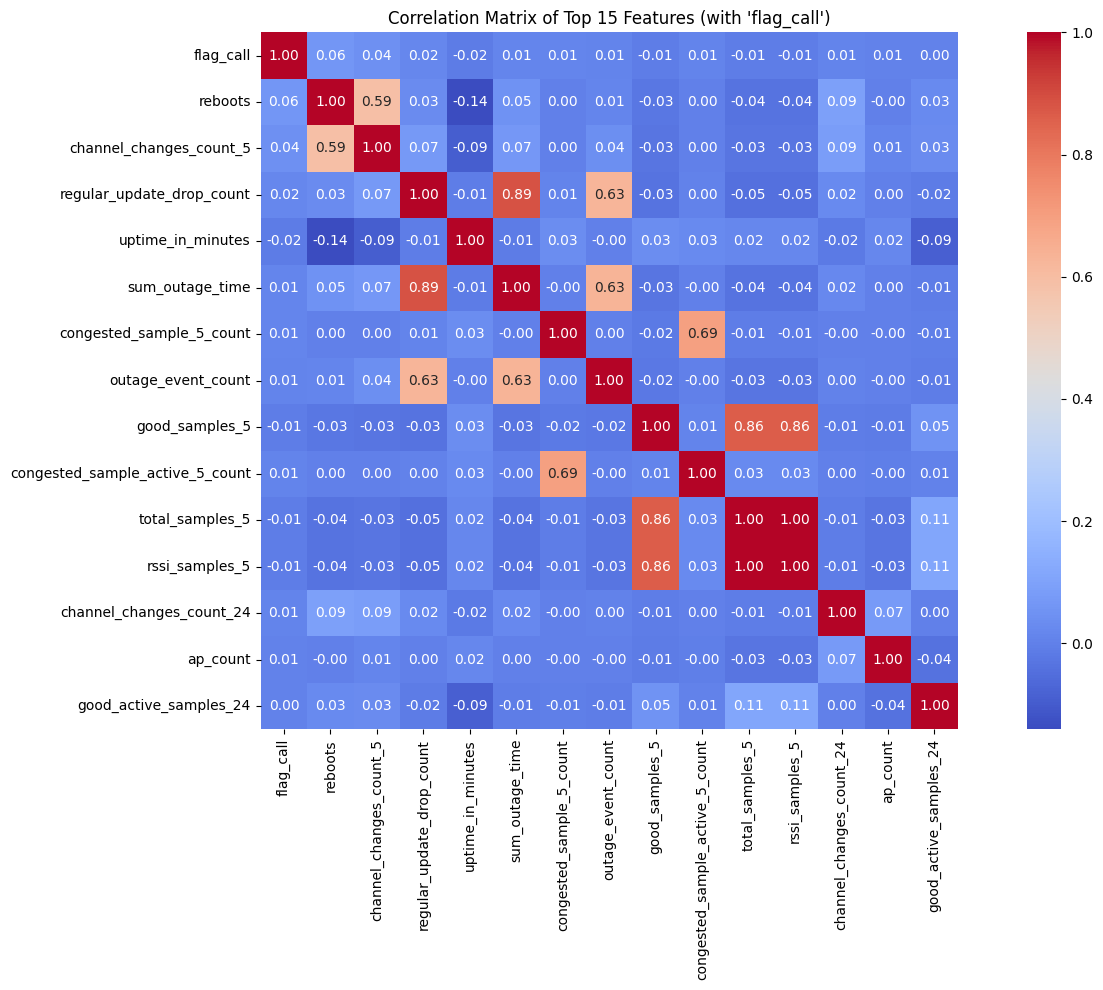

19107

In [ ]:
# Get only numeric columns
numeric_cols = df_merged.select_dtypes(include=["number"]).columns


# Drop columns with NaN
df_numeric = df_merged[numeric_cols].dropna(axis=1).copy()

# Get top 15 features most correlated (absolute) with flag_fault
top_15_corr_cols = (
    df_numeric.corrwith(df_merged["flag_call"])
    .abs()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Add 'flag_fault' to the selected columns
selected_cols = top_15_corr_cols.tolist()

# Plot correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_merged[selected_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Top 15 Features (with 'flag_call')")
plt.tight_layout()
plt.show()


del df_numeric

gc.collect()

# Feature Engineering - Predict Wifi Fault

## Ordinal Encoder

In [ ]:
# Ensure the column is string type
df_merged['congestion_5_status'] = df_merged['congestion_5_status'].astype(str)
df_merged['congestion_24_status'] = df_merged['congestion_24_status'].astype(str)
df_merged['band_usage_24_status'] = df_merged['band_usage_24_status'].astype(str)
df_merged['wifi_qoe_status'] = df_merged['wifi_qoe_status'].astype(str)

# # Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'GOOD']])

# Apply ordinal encoding
df_merged['congestion_5_status'] = encoder.fit_transform(df_merged[['congestion_5_status']])
df_merged['congestion_24_status'] = encoder.fit_transform(df_merged[['congestion_24_status']])
df_merged['band_usage_24_status'] = encoder.fit_transform(df_merged[['band_usage_24_status']])
df_merged['wifi_qoe_status'] = encoder.fit_transform(df_merged[['wifi_qoe_status']])


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status', 'wifi_qoe_status']]

,congestion_5_status,congestion_24_status,band_usage_24_status,wifi_qoe_status
2692,2.0,2.0,2.0,2.0
15260,2.0,1.0,2.0,0.0
7661,0.0,1.0,2.0,1.0
5019,0.0,2.0,2.0,2.0
3630,2.0,2.0,2.0,2.0
...,...,...,...,...
599426,2.0,2.0,2.0,2.0
597941,2.0,2.0,2.0,2.0
594071,2.0,2.0,2.0,2.0
584107,2.0,1.0,1.0,2.0


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status', 'wifi_qoe_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 519455 entries, 2692 to 585984
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   congestion_5_status   519455 non-null  float64
 1   congestion_24_status  519455 non-null  float64
 2   band_usage_24_status  519455 non-null  float64
 3   wifi_qoe_status       519455 non-null  float64
dtypes: float64(4)
memory usage: 19.8 MB


In [ ]:
# Ensure the column is string type
df_merged['wifi_coverage_status'] = df_merged['wifi_coverage_status'].astype(str)
df_merged['wifi_coverage_24_status'] = df_merged['wifi_coverage_24_status'].astype(str)
df_merged['wifi_coverage_5_status'] = df_merged['wifi_coverage_5_status'].astype(str)

# Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'HIGH']])

# Apply ordinal encoding
df_merged['wifi_coverage_status'] = encoder.fit_transform(df_merged[['wifi_coverage_status']])
df_merged['wifi_coverage_24_status'] = encoder.fit_transform(df_merged[['wifi_coverage_24_status']])
df_merged['wifi_coverage_5_status'] = encoder.fit_transform(df_merged[['wifi_coverage_5_status']])

In [ ]:
# Check data types for encoding columns
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 519455 entries, 2692 to 585984
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wifi_coverage_status     519455 non-null  float64
 1   wifi_coverage_24_status  519455 non-null  float64
 2   wifi_coverage_5_status   519455 non-null  float64
dtypes: float64(3)
memory usage: 15.9 MB


In [ ]:
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']]

,wifi_coverage_status,wifi_coverage_24_status,wifi_coverage_5_status
2692,2.0,2.0,1.0
15260,0.0,1.0,0.0
7661,2.0,2.0,2.0
5019,2.0,1.0,1.0
3630,2.0,0.0,2.0
...,...,...,...
599426,1.0,2.0,1.0
597941,2.0,2.0,2.0
594071,0.0,0.0,2.0
584107,2.0,2.0,2.0


In [ ]:
df_merged.shape

(519455, 60)

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,total_samples_24_non_iot,band_usage_24_status,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,mem_usage,high_mem_usage_samples,chunk_number,flag_call
2692,0005970190,2025-06-11,0,0,0,368,1557,351,1311,11,...,368,2.0,0,0,0.0,0.0,57.21,0,1,0
15260,ab7f2270de,2025-06-11,0,0,0,70,3634,55,2081,142,...,70,2.0,0,0,0.0,0.0,59.47,0,6,0
7661,ab8b015600,2025-06-11,0,0,0,2850,7610,1882,5625,56,...,2850,2.0,0,0,0.0,0.0,52.19,0,3,0
5019,ab8dc0e35c,2025-06-11,0,0,0,3105,10386,231,10286,43,...,3105,2.0,9,1,0.0,0.0,25.17,0,2,0
3630,188a7fa684,2025-06-11,0,0,0,27,2001,5,1715,0,...,27,2.0,2,0,0.0,0.0,69.78,0,1,0


## Ensure device_id exist across all dates

In [ ]:
# Filter device_id that exist across all dates
def filter_devices_with_complete_dates(df, device_col='device_id', date_col='analysis_date'):

    # Ensure datetime format ---
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Get all unique dates in the dataset ---
    all_dates = np.sort(df[date_col].unique())
    n_dates = len(all_dates)
    print(f" Total unique dates in dataset: {n_dates}")

    # Count unique dates per device ---
    device_date_counts = df.groupby(device_col)[date_col].nunique()

    # Identify complete devices ---
    complete_devices = device_date_counts[device_date_counts == n_dates].index
    n_complete = len(complete_devices)
    print(f" Found {n_complete} devices with complete date coverage (out of {len(device_date_counts)})")

    # Filter the DataFrame ---
    df_complete = df[df[device_col].isin(complete_devices)].copy()

    # Verify result ---
    remaining_devices = df_complete[device_col].nunique()
    assert remaining_devices == n_complete, " Filtering failed — counts don't match!"
    print(f" Final DataFrame contains {remaining_devices} devices with full date coverage")

    return df_complete

In [ ]:
df_merged = filter_devices_with_complete_dates(df_merged)

print(f' df_merged shape {df_merged.shape}')

 Total unique dates in dataset: 30
 Found 14799 devices with complete date coverage (out of 17904)
 Final DataFrame contains 14799 devices with full date coverage
 df_merged shape (443970, 60)


## Manual Feature Engineering

In [ ]:
# Create Manual Ferature Engineering
def manual_feature_engineering(df):
    # df = df.copy()

    # Ratios
    df['poor_coverage_ratio_24'] = df['poor_samples_24'] / (df['total_active_samples_24'] + 1e-6)
    df['poor_coverage_ratio_5'] = df['poor_samples_5'] / (df['total_active_samples_5'] + 1e-6)
    df['poor_coverage_ratio_total'] = (df['poor_samples_5'] + df['poor_samples_24']) / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    df['active_poor_ratio_24'] = df['poor_active_samples_24'] / (df['total_active_samples_24'] + 1e-6)
    df['active_poor_ratio_5'] = df['poor_active_samples_5'] / (df['total_active_samples_5'] + 1e-6)
    df['active_poor_ratio_total'] = (df['poor_active_samples_24'] + df['poor_active_samples_5']) / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    df['total_stations_per_hour'] = df['number_of_wifi_clients'] / (df['uptime_in_minutes'] / 60 + 1e-6)

    # -Band preference and congestion ratios
    df['congestion_ratio_24'] = df['congested_sample_24_count'] / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)
    df['congestion_ratio_5'] = df['congested_sample_5_count'] / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    return df


In [ ]:
df_merged = manual_feature_engineering(df_merged)

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,flag_call,poor_coverage_ratio_24,poor_coverage_ratio_5,poor_coverage_ratio_total,active_poor_ratio_24,active_poor_ratio_5,active_poor_ratio_total,total_stations_per_hour,congestion_ratio_24,congestion_ratio_5
2692,0005970190,2025-06-11,0,0,0,368,1557,351,1311,11,...,0,0.000000,0.077093,0.050725,0.000000,0.037445,0.024638,0.110571,0.001449,0.000000
15260,ab7f2270de,2025-06-11,0,0,0,70,3634,55,2081,142,...,0,0.000000,0.983854,0.962105,0.000000,0.541442,0.529474,0.011102,0.732632,0.002105
7661,ab8b015600,2025-06-11,0,0,0,2850,7610,1882,5625,56,...,0,0.000000,0.002020,0.001364,0.000000,0.000000,0.000000,0.006389,0.047749,0.107776
5019,ab8dc0e35c,2025-06-11,0,0,0,3105,10386,231,10286,43,...,0,0.087379,0.004241,0.010920,0.009709,0.000000,0.000780,0.405742,0.007800,0.017161
47,ab8df22c51,2025-06-11,1,0,0,0,110,0,109,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.465031,0.000000,0.000000


## Lag Features

In [ ]:
# Generated 1-day lag features

def add_top_lag_features(df, group_col='device_id', target_col='flag_call',
                         n_features=20, lag_period=1, verbose=True):

    # Identify numeric columns (excluding target)
    numeric_cols = df.select_dtypes(include='number').columns.difference([target_col])

    # Compute lag features
    lag_suffix = f'.lag{lag_period}'
    df_lagged = df.groupby(group_col)[numeric_cols].shift(lag_period).add_suffix(lag_suffix)

    # Compute correlations
    cor_df = df_lagged.copy()
    cor_df[target_col] = df[target_col].values
    correlations = cor_df.corr()[target_col].drop(target_col)

    # Select top N features
    top_features = correlations.abs().nlargest(n_features)
    top_lag_cols = top_features.index.tolist()

    # Merge top features with original data
    df_output = pd.concat([df, df_lagged[top_lag_cols]], axis=1)

    # Print output
    if verbose:
        print(f"\nTop {n_features} lag-{lag_period} correlated features with {target_col}:")
        for col in top_lag_cols:
            print(f"{col:.<30} correlation = {correlations[col]:.4f}")
        print(f"\nAdded {len(top_lag_cols)} lag features to DataFrame")

    return df_output, correlations

## Create rolling delta featrues

In [ ]:
# Create day over day deltas od selected features
def compute_rolling_deltas(df, date_col='analysis_date', group_col='device_id'):

    # Sort by device and time
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([group_col, date_col])

    # Define base variables
    base_vars = [
        "reboots", "script_boots", "ap_count", "total_samples_24", "total_samples_5",
        "good_samples_24", "good_samples_5", "poor_qoe_samples_24",
        "poor_iot_weighted_samples_24", "channel_changes_count_24",
        "mem_usage", "high_mem_usage_samples"
    ]

    # Add wildcard-matched variables
    pattern_vars = df.columns[df.columns.str.contains("congested_sample_|poor_coverage_ratio_")].tolist()

    all_vars = base_vars + pattern_vars

    # Compute deltas per group
    for var in all_vars:
        if var in df.columns:
            delta_col = f'delta_{var}'
            df[delta_col] = df.groupby(group_col)[var].diff()

    return df

In [ ]:
# Apply the delta computation
df_merged = compute_rolling_deltas(df_merged)

In [ ]:
# Drop rows with ANY NaN values (strict)
df_merged = df_merged.dropna(how='any')

In [ ]:
df_merged['analysis_date'].nunique()

29

In [ ]:
df_merged['analysis_date'].sort_values()
print(df_merged['analysis_date'].unique())

<DatetimeArray>
['2025-06-12 00:00:00', '2025-06-13 00:00:00', '2025-06-14 00:00:00',
 '2025-06-15 00:00:00', '2025-06-16 00:00:00', '2025-06-17 00:00:00',
 '2025-06-18 00:00:00', '2025-06-19 00:00:00', '2025-06-20 00:00:00',
 '2025-06-21 00:00:00', '2025-06-22 00:00:00', '2025-06-23 00:00:00',
 '2025-06-24 00:00:00', '2025-06-25 00:00:00', '2025-06-26 00:00:00',
 '2025-06-27 00:00:00', '2025-06-28 00:00:00', '2025-06-29 00:00:00',
 '2025-06-30 00:00:00', '2025-07-01 00:00:00', '2025-07-02 00:00:00',
 '2025-07-03 00:00:00', '2025-07-04 00:00:00', '2025-07-05 00:00:00',
 '2025-07-06 00:00:00', '2025-07-07 00:00:00', '2025-07-08 00:00:00',
 '2025-07-09 00:00:00', '2025-07-10 00:00:00']
Length: 29, dtype: datetime64[ns]


## Slice the data into train/validate/test

In [ ]:
# # Slice data into train/validate/test set according to days
# def slice_time_based_sets(df, train_days=22, val_days=3, test_days=3):
#     df = df.copy()
#     df['analysis_date'] = pd.to_datetime(df['analysis_date'])
#     start_date = df['analysis_date'].min()

#     train_cutoff = start_date + timedelta(days=train_days - 1)
#     val_cutoff = train_cutoff + timedelta(days=val_days)

#     df_train = df[df['analysis_date'] <= train_cutoff]
#     df_val = df[(df['analysis_date'] > train_cutoff) & (df['analysis_date'] <= val_cutoff)]
#     df_test = df[df['analysis_date'] > val_cutoff]

#     return df_train, df_val, df_test

In [ ]:
# # Print Time-based slicing data
# df_train, df_val, df_test = slice_time_based_sets(df_merged)

# print(f' df_train shape {df_train.shape}')
# print(f' df_val shape {df_val.shape}')
# print(f' df_test shape {df_test.shape}')

 df_train shape (325578, 87)
 df_val shape (44397, 87)
 df_test shape (59196, 87)


## Anomaly Score Feature


In [ ]:
# Prepare features - ensure all datasets have same columns
common_cols = list(set(df_merged))
cols_to_keep = [col for col in common_cols if col not in ['device_id', 'analysis_date', 'flag_call']]

# Align all datasets to use the same features
selected_features = df_merged[cols_to_keep]

# Fit only on training data (remove extra fits)
anomaly_model = IsolationForest(n_estimators=100, contamination=0.005, random_state=42)
anomaly_model.fit(selected_features)  # Fit ONLY ONCE

# Apply to all datasets
df_merged['anomaly_score'] = -anomaly_model.decision_function(selected_features)

# Optimize RAM
del selected_features, anomaly_model
gc.collect()

69

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_mem_usage,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,anomaly_score
25166,0005970190,2025-06-12,0,0,0,78,1657,73,1347,8,...,0.83,0.0,0.0,0.0,3.0,0.0,0.000000,0.082532,0.078063,-0.186403
388729,0005970190,2025-06-13,0,0,0,180,1348,176,1182,13,...,0.23,0.0,0.0,0.0,4.0,0.0,0.000000,-0.045940,-0.038788,-0.188617
45293,0005970190,2025-06-14,0,0,0,109,2569,95,2016,24,...,0.30,0.0,0.0,0.0,12.0,0.0,0.000000,-0.042840,-0.024010,-0.181548
70999,0005970190,2025-06-15,0,0,0,55,2138,50,1707,19,...,0.05,0.0,0.0,0.0,-10.0,-1.0,0.000000,0.076214,0.075854,-0.187184
93269,0005970190,2025-06-16,1,0,0,1109,2112,1012,1655,22,...,-0.44,0.0,0.0,0.0,-2.0,8.0,0.002004,-0.022059,-0.089649,-0.099035


In [ ]:
# count unique customer of df_train
print(f"Number of customers in df_merged: {df_merged['device_id'].nunique()}")

Number of customers in df_merged: 14799


## Balance the df_train

In [ ]:
# # Identify total number of unique dates
# expected_days = df_train["analysis_date"].nunique()
# print(f" Total unique dates: {expected_days}")

# # Select all device_ids with at least one call (positive class)
# positive_ids = df_train[df_train["flag_call"] == 1]["device_id"].unique()
# df_positive = df_train[df_train["device_id"].isin(positive_ids)].copy()

# # Filter positive devices with full date coverage
# pos_date_counts = df_positive.groupby("device_id")["analysis_date"].nunique()
# valid_positive_ids = pos_date_counts[pos_date_counts == expected_days].index
# df_positive = df_positive[df_positive["device_id"].isin(valid_positive_ids)].copy()
# print(f" Positive devices with full coverage: {df_positive['device_id'].nunique()}")

# # Select negative device_ids (never called)
# all_ids = df_train["device_id"].unique()
# negative_ids = np.setdiff1d(all_ids, positive_ids)
# df_negative = df_train[df_train["device_id"].isin(negative_ids)].copy()

# # Filter negative devices with full date coverage
# neg_date_counts = df_negative.groupby("device_id")["analysis_date"].nunique()
# valid_negative_ids = neg_date_counts[neg_date_counts == expected_days].index
# df_negative = df_negative[df_negative["device_id"].isin(valid_negative_ids)].copy()
# print(f" Negative devices with full coverage: {df_negative['device_id'].nunique()}")

# # Sample negative devices 5 times of positive devices
# n_pos = df_positive["device_id"].nunique()
# sampled_neg_ids = np.random.choice(valid_negative_ids, size=n_pos * 5, replace=False)
# df_negative_sampled = df_negative[df_negative["device_id"].isin(sampled_neg_ids)].copy()
# print(f" Sampled negative devices: {df_negative_sampled['device_id'].nunique()}")

# # Merge positive and sampled negative data
# df_train_balanced = pd.concat([df_positive, df_negative_sampled], ignore_index=True)
# df_train_balanced = df_train_balanced.sort_values(["device_id", "analysis_date"])
# print(f" Final balanced dataset shape: {df_train_balanced.shape}")

# del expected_days
# del positive_ids
# del df_positive
# del pos_date_counts
# del valid_positive_ids
# del all_ids
# del negative_ids
# del df_negative
# del neg_date_counts
# del valid_negative_ids
# del n_pos
# del sampled_neg_ids
# del df_negative_sampled

# gc.collect()

In [ ]:
# print("Train Sample:", df_train_balanced['flag_call'].value_counts())

In [ ]:
# df_train_balanced.shape

In [ ]:
# Double check
# Count total number of unique dates in df_balanced
expected_days = df_merged["analysis_date"].nunique()
print(f" Total unique dates in df_balanced: {expected_days}")

# Count how many unique dates each device_id appears on
device_date_counts = df_merged.groupby("device_id")["analysis_date"].nunique()

# Identify devices that are missing any dates
missing_devices = device_date_counts[device_date_counts < expected_days].index
print(f" Devices missing some dates: {len(missing_devices)}")

del expected_days
del device_date_counts
del missing_devices

gc.collect()

 Total unique dates in df_balanced: 29
 Devices missing some dates: 0


0

## Select Sample for validation and test set

In [ ]:
# # Select sample data for validation and test set
# def stratified_device_sample_per_day(df, device_col='device_id', label_col='flag_call',
#                                      date_col='analysis_date', max_devices=400_000, random_state=42):
#     df = df.copy()
#     df[date_col] = pd.to_datetime(df[date_col])

#     sampled_frames = []

#     for day, df_day in df.groupby(date_col):
#         device_labels = (
#             df_day.groupby(device_col)[label_col]
#             .max()
#             .reset_index()
#         )

#         n_devices = min(max_devices, len(device_labels))

#         # Use train_size instead of test_size to keep exactly n_devices
#         splitter = StratifiedShuffleSplit(n_splits=1, train_size=n_devices, random_state=random_state)

#         try:
#             for train_idx, _ in splitter.split(device_labels, device_labels[label_col]):
#                 selected_devices = device_labels.loc[train_idx, device_col]

#             df_selected = df_day[df_day[device_col].isin(selected_devices)].copy()
#             sampled_frames.append(df_selected)

#         except ValueError:
#             # Fallback to random sample if stratified split fails
#             fallback_devices = device_labels[device_col].sample(n=n_devices, random_state=random_state)
#             df_selected = df_day[df_day[device_col].isin(fallback_devices)].copy()
#             sampled_frames.append(df_selected)

#     df_sampled = pd.concat(sampled_frames, ignore_index=True)
#     return df_sampled


In [ ]:
# df_val_sampled = stratified_device_sample_per_day(df_val, max_devices=50_000)

# print(df_val_sampled.groupby('analysis_date')['device_id'].nunique())
# print("Original class ratio:", df_val['flag_call'].mean())
# print("Sampled class ratio:", df_val_sampled['flag_call'].mean())
# print("df_val_sampled:", df_val_sampled.shape)

In [ ]:
# print("Validation Sample:", df_val_sampled['flag_call'].value_counts())

In [ ]:
# df_test_sampled = stratified_device_sample_per_day(df_test, max_devices=50_000)

# print(df_test_sampled.groupby('analysis_date')['device_id'].nunique())
# print("Original class ratio:", df_test['flag_call'].mean())
# print("Sampled class ratio:", df_test_sampled['flag_call'].mean())
# print("df_test_sampled:", df_test_sampled.shape)

In [ ]:
# print("Test Sample:", df_test_sampled['flag_call'].value_counts())

In [ ]:
# del df_train
# del df_val
# del df_test

# gc.collect()

In [ ]:
# df_train_balanced.shape

In [ ]:
# df_val_sampled.shape

In [ ]:
# df_val_sampled

In [ ]:
# df_test_sampled.shape

## Create rolling window with label t+1

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_mem_usage,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,anomaly_score
25166,0005970190,2025-06-12,0,0,0,78,1657,73,1347,8,...,0.83,0.0,0.0,0.0,3.0,0.0,0.000000,0.082532,0.078063,-0.186403
388729,0005970190,2025-06-13,0,0,0,180,1348,176,1182,13,...,0.23,0.0,0.0,0.0,4.0,0.0,0.000000,-0.045940,-0.038788,-0.188617
45293,0005970190,2025-06-14,0,0,0,109,2569,95,2016,24,...,0.30,0.0,0.0,0.0,12.0,0.0,0.000000,-0.042840,-0.024010,-0.181548
70999,0005970190,2025-06-15,0,0,0,55,2138,50,1707,19,...,0.05,0.0,0.0,0.0,-10.0,-1.0,0.000000,0.076214,0.075854,-0.187184
93269,0005970190,2025-06-16,1,0,0,1109,2112,1012,1655,22,...,-0.44,0.0,0.0,0.0,-2.0,8.0,0.002004,-0.022059,-0.089649,-0.099035


In [ ]:
# Create rolling windows of 3-days wrapped in a TSFRESH format
def create_rolling_windows_for_tsfresh(df, max_window_size=3, verbose=True):

    rolling_windows = []
    positive_count = 0
    negative_count = 0
    global_id = 0

    df = df.sort_values(['device_id', 'analysis_date'])

    for device_id, group in df.groupby('device_id'):
        group = group.reset_index(drop=True)
        n = len(group)

        if n < 2:
            continue

        window_size = min(max_window_size, n - 1)

        for i in range(n - window_size):
            label_row = group.iloc[i + window_size]
            label = label_row['flag_call']

            if pd.isna(label):
                continue

            if verbose and label == 1:
                print(f"[{device_id}] Positive at {label_row['analysis_date']}")

            window = group.iloc[i:i + window_size].drop(columns=['device_id', 'analysis_date', 'flag_call'])
            window = window.select_dtypes(include='number')

            # Add TSFRESH-specific fields window
            window_df = window.copy()
            window_df['id'] = global_id
            window_df['time'] = np.arange(len(window_df))

            # Wrap into 4-element tuple
            rolling_windows.append((window_df, device_id, label_row['analysis_date'], label))

            if label == 1:
                positive_count += 1
            else:
                negative_count += 1

            global_id += 1

    label_summary = {
        'positive': positive_count,
        'negative': negative_count
    }

    if verbose:
        print(f" Created {len(rolling_windows)} windows → Pos: {positive_count}, Neg: {negative_count}")

    return rolling_windows, label_summary


In [ ]:
rolling_windows, summary = create_rolling_windows_for_tsfresh(df_merged)


[006306db2c] Positive at 2025-06-20 00:00:00
[01752bf0a5] Positive at 2025-07-05 00:00:00
[02d1ff3e91] Positive at 2025-06-20 00:00:00
[04c6f66b43] Positive at 2025-06-18 00:00:00
[072390dcda] Positive at 2025-07-02 00:00:00
[07448e5089] Positive at 2025-06-19 00:00:00
[07a0e1ca61] Positive at 2025-06-18 00:00:00
[07a32b791f] Positive at 2025-06-28 00:00:00
[092398c839] Positive at 2025-07-03 00:00:00
[0b4d6da8c5] Positive at 2025-06-24 00:00:00
[0b93626362] Positive at 2025-06-26 00:00:00
[0b93626362] Positive at 2025-06-27 00:00:00
[0deb724128] Positive at 2025-07-05 00:00:00
[0e37303fb3] Positive at 2025-06-17 00:00:00
[0f20066893] Positive at 2025-07-04 00:00:00
[0f52baae7d] Positive at 2025-06-24 00:00:00
[0f57bf218c] Positive at 2025-06-18 00:00:00
[0fb9183fb8] Positive at 2025-06-23 00:00:00
[101c490e7a] Positive at 2025-07-08 00:00:00
[110b2641e3] Positive at 2025-06-19 00:00:00
[1121cb488f] Positive at 2025-07-06 00:00:00
[116b3effee] Positive at 2025-07-04 00:00:00
[12d433ad5

In [ ]:
print("Total Windows:", len(rolling_windows))

Total Windows: 384774


In [ ]:
# rolling_windows_val_sampled, summary = create_rolling_windows_for_tsfresh(df_val_sampled)

# del df_val_sampled

# gc.collect()

In [ ]:
# rolling_windows_test_sampled, summary = create_rolling_windows_for_tsfresh(df_test_sampled)

# del df_test_sampled

# gc.collect()

In [ ]:
# print("Train Windows:", len(rolling_windows_train_balanced))
# print("Validate Windows:", len(rolling_windows_val_sampled))
# print("Test Windows:", len(rolling_windows_test_sampled))


## TSFRESH

In [ ]:
# Generate TSFRESH features from rolling windows
def generate_tsfresh_features_chunked(rolling_windows, chunk_size=500, verbose=True):

    all_features = []

    for batch_start in range(0, len(rolling_windows), chunk_size):
        chunk = rolling_windows[batch_start:batch_start + chunk_size]

        ts_list = []
        metadata_list = []

        for local_id, (window_df, device_id, label_date, flag_call) in enumerate(chunk):
            # Select only numeric columns to avoid TSFRESH errors
            ts_numeric = window_df.select_dtypes(include='number').copy()
            ts_numeric['id'] = local_id
            ts_numeric['time'] = np.arange(len(ts_numeric))

            ts_list.append(ts_numeric)
            metadata_list.append({
                'id': local_id,
                'device_id': device_id,
                'analysis_date': label_date,
                'flag_call': flag_call
            })

        df_ts = pd.concat(ts_list, ignore_index=True)
        metadata_df = pd.DataFrame(metadata_list)

        # Run TSFRESH
        features = extract_features(
            df_ts,
            column_id='id',
            column_sort='time',
            default_fc_parameters=MinimalFCParameters(),
            disable_progressbar=False,
            n_jobs=1
        )

        impute(features)

        features = features.reset_index().rename(columns={'index': 'id'})
        features = features.merge(metadata_df, on='id', how='left').drop(columns=['id'])

        all_features.append(features)

        if verbose:
            print(f" Processed chunk {batch_start // chunk_size + 1} "
                  f"of {int(np.ceil(len(rolling_windows) / chunk_size))} → {features.shape}")

    return pd.concat(all_features, ignore_index=True)


In [ ]:
df_tsfresh = generate_tsfresh_features_chunked(rolling_windows)

print("df_tsfresh:", df_tsfresh.shape)

del rolling_windows

gc.collect()

Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4633.28it/s]


 Processed chunk 1 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4717.16it/s]


 Processed chunk 2 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4636.29it/s]


 Processed chunk 3 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4654.94it/s]


 Processed chunk 4 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:17<00:00, 2367.46it/s]


 Processed chunk 5 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4646.82it/s]


 Processed chunk 6 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4593.19it/s]


 Processed chunk 7 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4518.95it/s]


 Processed chunk 8 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4518.50it/s]


 Processed chunk 9 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4527.70it/s]


 Processed chunk 10 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4597.72it/s]


 Processed chunk 11 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4563.96it/s]


 Processed chunk 12 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4654.01it/s]


 Processed chunk 13 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4399.43it/s]


 Processed chunk 14 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4498.01it/s]


 Processed chunk 15 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4468.78it/s]


 Processed chunk 16 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4370.45it/s]


 Processed chunk 17 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4439.17it/s]


 Processed chunk 18 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4400.74it/s]


 Processed chunk 19 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4183.06it/s]


 Processed chunk 20 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4276.71it/s]


 Processed chunk 21 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4500.55it/s]


 Processed chunk 22 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4562.48it/s]


 Processed chunk 23 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4379.64it/s]


 Processed chunk 24 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4457.70it/s]


 Processed chunk 25 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4220.98it/s]


 Processed chunk 26 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4536.20it/s]


 Processed chunk 27 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4594.34it/s]


 Processed chunk 28 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4523.40it/s]


 Processed chunk 29 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4533.13it/s]


 Processed chunk 30 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4492.33it/s]


 Processed chunk 31 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4466.78it/s]


 Processed chunk 32 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4556.98it/s]


 Processed chunk 33 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4632.99it/s]


 Processed chunk 34 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4537.07it/s]


 Processed chunk 35 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4305.30it/s]


 Processed chunk 36 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4165.65it/s]


 Processed chunk 37 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4346.57it/s]


 Processed chunk 38 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4228.68it/s]


 Processed chunk 39 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4362.56it/s]


 Processed chunk 40 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4323.05it/s]


 Processed chunk 41 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4295.73it/s]


 Processed chunk 42 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4359.84it/s]


 Processed chunk 43 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4288.71it/s]


 Processed chunk 44 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4097.52it/s]


 Processed chunk 45 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4218.18it/s]


 Processed chunk 46 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4137.70it/s]


 Processed chunk 47 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3882.98it/s]


 Processed chunk 48 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4178.07it/s]


 Processed chunk 49 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4389.74it/s]


 Processed chunk 50 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4418.72it/s]


 Processed chunk 51 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4285.09it/s]


 Processed chunk 52 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4284.51it/s]


 Processed chunk 53 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4227.13it/s]


 Processed chunk 54 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4357.74it/s]


 Processed chunk 55 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4349.04it/s]


 Processed chunk 56 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4451.55it/s]


 Processed chunk 57 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4319.10it/s]


 Processed chunk 58 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4487.00it/s]


 Processed chunk 59 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4498.59it/s]


 Processed chunk 60 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4596.46it/s]


 Processed chunk 61 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4596.04it/s]


 Processed chunk 62 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4604.36it/s]


 Processed chunk 63 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4494.02it/s]


 Processed chunk 64 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4659.36it/s]


 Processed chunk 65 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4397.49it/s]


 Processed chunk 66 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4389.93it/s]


 Processed chunk 67 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4349.25it/s]


 Processed chunk 68 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4220.52it/s]


 Processed chunk 69 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4112.15it/s]


 Processed chunk 70 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4328.28it/s]


 Processed chunk 71 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4364.28it/s]


 Processed chunk 72 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4294.13it/s]


 Processed chunk 73 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4324.30it/s]


 Processed chunk 74 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4289.61it/s]


 Processed chunk 75 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4458.35it/s]


 Processed chunk 76 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4313.54it/s]


 Processed chunk 77 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4376.22it/s]


 Processed chunk 78 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4048.47it/s]


 Processed chunk 79 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4289.10it/s]


 Processed chunk 80 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4102.57it/s]


 Processed chunk 81 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4224.98it/s]


 Processed chunk 82 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4046.58it/s]


 Processed chunk 83 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4173.82it/s]


 Processed chunk 84 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4036.55it/s]


 Processed chunk 85 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4241.18it/s]


 Processed chunk 86 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:22<00:00, 1887.79it/s]


 Processed chunk 87 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4286.18it/s]


 Processed chunk 88 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4384.99it/s]


 Processed chunk 89 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4259.90it/s]


 Processed chunk 90 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4301.40it/s]


 Processed chunk 91 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4353.14it/s]


 Processed chunk 92 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4357.82it/s]


 Processed chunk 93 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4270.92it/s]


 Processed chunk 94 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4180.46it/s]


 Processed chunk 95 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4437.89it/s]


 Processed chunk 96 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4559.95it/s]


 Processed chunk 97 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4433.98it/s]


 Processed chunk 98 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4404.97it/s]


 Processed chunk 99 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4390.22it/s]


 Processed chunk 100 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4320.19it/s]


 Processed chunk 101 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4378.84it/s]


 Processed chunk 102 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4505.14it/s]


 Processed chunk 103 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4483.64it/s]


 Processed chunk 104 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4282.87it/s]


 Processed chunk 105 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4273.02it/s]


 Processed chunk 106 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4465.96it/s]


 Processed chunk 107 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4507.67it/s]


 Processed chunk 108 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4534.24it/s]


 Processed chunk 109 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4476.92it/s]


 Processed chunk 110 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4232.93it/s]


 Processed chunk 111 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4458.91it/s]


 Processed chunk 112 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4497.10it/s]


 Processed chunk 113 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4420.54it/s]


 Processed chunk 114 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4510.94it/s]


 Processed chunk 115 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4441.56it/s]


 Processed chunk 116 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4509.23it/s]


 Processed chunk 117 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4499.74it/s]


 Processed chunk 118 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4515.31it/s]


 Processed chunk 119 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4421.59it/s]


 Processed chunk 120 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4437.08it/s]


 Processed chunk 121 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4482.32it/s]


 Processed chunk 122 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4140.53it/s]


 Processed chunk 123 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4456.38it/s]


 Processed chunk 124 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4424.75it/s]


 Processed chunk 125 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4119.53it/s]


 Processed chunk 126 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4330.20it/s]


 Processed chunk 127 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4321.61it/s]


 Processed chunk 128 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4325.40it/s]


 Processed chunk 129 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4379.10it/s]


 Processed chunk 130 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4397.95it/s]


 Processed chunk 131 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4210.90it/s]


 Processed chunk 132 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4090.10it/s]


 Processed chunk 133 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4297.07it/s]


 Processed chunk 134 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4463.55it/s]


 Processed chunk 135 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4590.73it/s]


 Processed chunk 136 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4511.07it/s]


 Processed chunk 137 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:22<00:00, 1918.67it/s]


 Processed chunk 138 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4589.94it/s]


 Processed chunk 139 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4566.00it/s]


 Processed chunk 140 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4587.55it/s]


 Processed chunk 141 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4418.52it/s]


 Processed chunk 142 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4300.58it/s]


 Processed chunk 143 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4374.60it/s]


 Processed chunk 144 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4378.62it/s]


 Processed chunk 145 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4501.64it/s]


 Processed chunk 146 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4554.39it/s]


 Processed chunk 147 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4462.69it/s]


 Processed chunk 148 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4402.43it/s]


 Processed chunk 149 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4252.28it/s]


 Processed chunk 150 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4387.68it/s]


 Processed chunk 151 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4244.28it/s]


 Processed chunk 152 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4403.00it/s]


 Processed chunk 153 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4159.74it/s]


 Processed chunk 154 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4163.52it/s]


 Processed chunk 155 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4290.86it/s]


 Processed chunk 156 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4398.74it/s]


 Processed chunk 157 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4331.39it/s]


 Processed chunk 158 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4397.24it/s]


 Processed chunk 159 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4330.11it/s]


 Processed chunk 160 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4269.63it/s]


 Processed chunk 161 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4259.27it/s]


 Processed chunk 162 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4171.17it/s]


 Processed chunk 163 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4265.94it/s]


 Processed chunk 164 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4250.04it/s]


 Processed chunk 165 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4094.13it/s]


 Processed chunk 166 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4204.29it/s]


 Processed chunk 167 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4042.65it/s]


 Processed chunk 168 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3898.45it/s]


 Processed chunk 169 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3944.61it/s]


 Processed chunk 170 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4039.85it/s]


 Processed chunk 171 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4382.16it/s]


 Processed chunk 172 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4305.12it/s]


 Processed chunk 173 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4207.01it/s]


 Processed chunk 174 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4268.28it/s]


 Processed chunk 175 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4283.46it/s]


 Processed chunk 176 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4253.52it/s]


 Processed chunk 177 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4239.42it/s]


 Processed chunk 178 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4230.14it/s]


 Processed chunk 179 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4154.30it/s]


 Processed chunk 180 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4285.83it/s]


 Processed chunk 181 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4225.79it/s]


 Processed chunk 182 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4245.36it/s]


 Processed chunk 183 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4104.43it/s]


 Processed chunk 184 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3954.48it/s]


 Processed chunk 185 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3893.37it/s]


 Processed chunk 186 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4108.34it/s]


 Processed chunk 187 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4174.42it/s]


 Processed chunk 188 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4191.87it/s]


 Processed chunk 189 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4270.27it/s]


 Processed chunk 190 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:21<00:00, 2006.13it/s]


 Processed chunk 191 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4404.35it/s]


 Processed chunk 192 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4373.12it/s]


 Processed chunk 193 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4313.53it/s]


 Processed chunk 194 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4423.07it/s]


 Processed chunk 195 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4337.21it/s]


 Processed chunk 196 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4320.87it/s]


 Processed chunk 197 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4428.10it/s]


 Processed chunk 198 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4345.87it/s]


 Processed chunk 199 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4389.34it/s]


 Processed chunk 200 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4287.05it/s]


 Processed chunk 201 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3662.51it/s]


 Processed chunk 202 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4168.47it/s]


 Processed chunk 203 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4303.51it/s]


 Processed chunk 204 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4298.34it/s]


 Processed chunk 205 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4223.52it/s]


 Processed chunk 206 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4241.47it/s]


 Processed chunk 207 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4163.48it/s]


 Processed chunk 208 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4172.20it/s]


 Processed chunk 209 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4246.66it/s]


 Processed chunk 210 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3981.83it/s]


 Processed chunk 211 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3776.28it/s]


 Processed chunk 212 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3664.95it/s]


 Processed chunk 213 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4261.63it/s]


 Processed chunk 214 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4033.99it/s]


 Processed chunk 215 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4231.29it/s]


 Processed chunk 216 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4310.25it/s]


 Processed chunk 217 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:20<00:00, 2035.08it/s]


 Processed chunk 218 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4298.43it/s]


 Processed chunk 219 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4301.64it/s]


 Processed chunk 220 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4057.99it/s]


 Processed chunk 221 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:13<00:00, 3250.38it/s]


 Processed chunk 222 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4068.39it/s]


 Processed chunk 223 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4199.77it/s]


 Processed chunk 224 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4208.30it/s]


 Processed chunk 225 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4289.31it/s]


 Processed chunk 226 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4085.06it/s]


 Processed chunk 227 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4173.25it/s]


 Processed chunk 228 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4279.39it/s]


 Processed chunk 229 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4409.29it/s]


 Processed chunk 230 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4438.67it/s]


 Processed chunk 231 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4341.85it/s]


 Processed chunk 232 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4204.85it/s]


 Processed chunk 233 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4482.44it/s]


 Processed chunk 234 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4232.06it/s]


 Processed chunk 235 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4230.06it/s]


 Processed chunk 236 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4439.22it/s]


 Processed chunk 237 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4301.50it/s]


 Processed chunk 238 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4346.31it/s]


 Processed chunk 239 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4579.03it/s]


 Processed chunk 240 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4503.52it/s]


 Processed chunk 241 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4462.36it/s]


 Processed chunk 242 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4462.59it/s]


 Processed chunk 243 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4335.30it/s]


 Processed chunk 244 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:21<00:00, 1942.65it/s]


 Processed chunk 245 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4044.68it/s]


 Processed chunk 246 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4096.85it/s]


 Processed chunk 247 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4203.94it/s]


 Processed chunk 248 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3998.29it/s]


 Processed chunk 249 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3855.64it/s]


 Processed chunk 250 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3795.57it/s]


 Processed chunk 251 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4115.39it/s]


 Processed chunk 252 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4370.05it/s]


 Processed chunk 253 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4484.62it/s]


 Processed chunk 254 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4349.97it/s]


 Processed chunk 255 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4211.39it/s]


 Processed chunk 256 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4160.62it/s]


 Processed chunk 257 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3981.88it/s]


 Processed chunk 258 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4148.69it/s]


 Processed chunk 259 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4415.41it/s]


 Processed chunk 260 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4196.62it/s]


 Processed chunk 261 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4349.81it/s]


 Processed chunk 262 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4223.62it/s]


 Processed chunk 263 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4243.15it/s]


 Processed chunk 264 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3637.55it/s]


 Processed chunk 265 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4379.05it/s]


 Processed chunk 266 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4280.35it/s]


 Processed chunk 267 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4185.52it/s]


 Processed chunk 268 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4243.07it/s]


 Processed chunk 269 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4083.46it/s]


 Processed chunk 270 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4339.59it/s]


 Processed chunk 271 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:20<00:00, 2082.70it/s]


 Processed chunk 272 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4356.19it/s]


 Processed chunk 273 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4159.41it/s]


 Processed chunk 274 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4229.17it/s]


 Processed chunk 275 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4322.18it/s]


 Processed chunk 276 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4260.52it/s]


 Processed chunk 277 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4306.81it/s]


 Processed chunk 278 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4205.35it/s]


 Processed chunk 279 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3985.08it/s]


 Processed chunk 280 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4094.11it/s]


 Processed chunk 281 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4053.65it/s]


 Processed chunk 282 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4251.88it/s]


 Processed chunk 283 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4109.26it/s]


 Processed chunk 284 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4354.84it/s]


 Processed chunk 285 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3748.18it/s]


 Processed chunk 286 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4268.29it/s]


 Processed chunk 287 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4153.14it/s]


 Processed chunk 288 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4213.36it/s]


 Processed chunk 289 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4268.63it/s]


 Processed chunk 290 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4185.29it/s]


 Processed chunk 291 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4321.12it/s]


 Processed chunk 292 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4427.29it/s]


 Processed chunk 293 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4343.12it/s]


 Processed chunk 294 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4175.51it/s]


 Processed chunk 295 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3944.07it/s]


 Processed chunk 296 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4200.07it/s]


 Processed chunk 297 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4309.72it/s]


 Processed chunk 298 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4246.63it/s]


 Processed chunk 299 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4279.64it/s]


 Processed chunk 300 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4521.03it/s]


 Processed chunk 301 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4467.21it/s]


 Processed chunk 302 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4472.28it/s]


 Processed chunk 303 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4491.82it/s]


 Processed chunk 304 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4444.39it/s]


 Processed chunk 305 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4433.44it/s]


 Processed chunk 306 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4106.36it/s]


 Processed chunk 307 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4422.87it/s]


 Processed chunk 308 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4400.87it/s]


 Processed chunk 309 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4182.30it/s]


 Processed chunk 310 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4111.20it/s]


 Processed chunk 311 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4276.49it/s]


 Processed chunk 312 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4101.92it/s]


 Processed chunk 313 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3842.49it/s]


 Processed chunk 314 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4010.11it/s]


 Processed chunk 315 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4014.72it/s]


 Processed chunk 316 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4218.20it/s]


 Processed chunk 317 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4084.01it/s]


 Processed chunk 318 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3982.09it/s]


 Processed chunk 319 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4165.68it/s]


 Processed chunk 320 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3957.09it/s]


 Processed chunk 321 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4103.21it/s]


 Processed chunk 322 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4177.13it/s]


 Processed chunk 323 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4162.02it/s]


 Processed chunk 324 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4174.14it/s]


 Processed chunk 325 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4217.77it/s]


 Processed chunk 326 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:23<00:00, 1816.57it/s]


 Processed chunk 327 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4310.01it/s]


 Processed chunk 328 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4375.19it/s]


 Processed chunk 329 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4307.01it/s]


 Processed chunk 330 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4156.56it/s]


 Processed chunk 331 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4432.38it/s]


 Processed chunk 332 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4409.26it/s]


 Processed chunk 333 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4509.01it/s]


 Processed chunk 334 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4161.64it/s]


 Processed chunk 335 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4350.41it/s]


 Processed chunk 336 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4351.32it/s]


 Processed chunk 337 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4362.14it/s]


 Processed chunk 338 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4120.71it/s]


 Processed chunk 339 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4141.05it/s]


 Processed chunk 340 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4103.84it/s]


 Processed chunk 341 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4227.63it/s]


 Processed chunk 342 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4168.85it/s]


 Processed chunk 343 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4285.43it/s]


 Processed chunk 344 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4442.60it/s]


 Processed chunk 345 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4482.61it/s]


 Processed chunk 346 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4163.85it/s]


 Processed chunk 347 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4352.43it/s]


 Processed chunk 348 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:12<00:00, 3527.82it/s]


 Processed chunk 349 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4503.21it/s]


 Processed chunk 350 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4382.06it/s]


 Processed chunk 351 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4223.27it/s]


 Processed chunk 352 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4255.14it/s]


 Processed chunk 353 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4296.73it/s]


 Processed chunk 354 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4389.99it/s]


 Processed chunk 355 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4455.24it/s]


 Processed chunk 356 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4409.88it/s]


 Processed chunk 357 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4619.09it/s]


 Processed chunk 358 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4421.93it/s]


 Processed chunk 359 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4430.20it/s]


 Processed chunk 360 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4430.22it/s]


 Processed chunk 361 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4362.13it/s]


 Processed chunk 362 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4469.86it/s]


 Processed chunk 363 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4551.54it/s]


 Processed chunk 364 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4496.00it/s]


 Processed chunk 365 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4371.31it/s]


 Processed chunk 366 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4483.67it/s]


 Processed chunk 367 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4382.73it/s]


 Processed chunk 368 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4422.03it/s]


 Processed chunk 369 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4481.23it/s]


 Processed chunk 370 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3691.25it/s]


 Processed chunk 371 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4424.98it/s]


 Processed chunk 372 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4279.03it/s]


 Processed chunk 373 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4306.75it/s]


 Processed chunk 374 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4416.63it/s]


 Processed chunk 375 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4456.23it/s]


 Processed chunk 376 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4449.32it/s]


 Processed chunk 377 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4497.14it/s]


 Processed chunk 378 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4396.29it/s]


 Processed chunk 379 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:23<00:00, 1818.96it/s]


 Processed chunk 380 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4500.58it/s]


 Processed chunk 381 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4345.63it/s]


 Processed chunk 382 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4226.99it/s]


 Processed chunk 383 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4273.96it/s]


 Processed chunk 384 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4272.91it/s]


 Processed chunk 385 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3989.59it/s]


 Processed chunk 386 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4367.17it/s]


 Processed chunk 387 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4524.47it/s]


 Processed chunk 388 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4361.61it/s]


 Processed chunk 389 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4349.84it/s]


 Processed chunk 390 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4344.93it/s]


 Processed chunk 391 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:12<00:00, 3313.68it/s]


 Processed chunk 392 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4217.47it/s]


 Processed chunk 393 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4195.24it/s]


 Processed chunk 394 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4156.06it/s]


 Processed chunk 395 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4266.14it/s]


 Processed chunk 396 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4239.50it/s]


 Processed chunk 397 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4377.63it/s]


 Processed chunk 398 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4458.47it/s]


 Processed chunk 399 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4334.21it/s]


 Processed chunk 400 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4447.52it/s]


 Processed chunk 401 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4444.51it/s]


 Processed chunk 402 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4455.20it/s]


 Processed chunk 403 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4418.70it/s]


 Processed chunk 404 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4144.63it/s]


 Processed chunk 405 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4410.01it/s]


 Processed chunk 406 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4394.20it/s]


 Processed chunk 407 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:21<00:00, 1966.56it/s]


 Processed chunk 408 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4358.88it/s]


 Processed chunk 409 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4257.31it/s]


 Processed chunk 410 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4284.22it/s]


 Processed chunk 411 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4123.70it/s]


 Processed chunk 412 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3574.62it/s]


 Processed chunk 413 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4175.35it/s]


 Processed chunk 414 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4362.70it/s]


 Processed chunk 415 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4474.16it/s]


 Processed chunk 416 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4612.59it/s]


 Processed chunk 417 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4549.32it/s]


 Processed chunk 418 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4444.14it/s]


 Processed chunk 419 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4603.72it/s]


 Processed chunk 420 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4579.09it/s]


 Processed chunk 421 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4507.19it/s]


 Processed chunk 422 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4508.12it/s]


 Processed chunk 423 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4555.68it/s]


 Processed chunk 424 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4314.69it/s]


 Processed chunk 425 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4423.81it/s]


 Processed chunk 426 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4540.11it/s]


 Processed chunk 427 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4298.16it/s]


 Processed chunk 428 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4447.16it/s]


 Processed chunk 429 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4453.45it/s]


 Processed chunk 430 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4553.28it/s]


 Processed chunk 431 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4411.50it/s]


 Processed chunk 432 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4525.76it/s]


 Processed chunk 433 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4569.48it/s]


 Processed chunk 434 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4369.58it/s]


 Processed chunk 435 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3991.55it/s]


 Processed chunk 436 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4359.05it/s]


 Processed chunk 437 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4405.49it/s]


 Processed chunk 438 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4630.26it/s]


 Processed chunk 439 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4486.17it/s]


 Processed chunk 440 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4493.83it/s]


 Processed chunk 441 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4486.26it/s]


 Processed chunk 442 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4487.36it/s]


 Processed chunk 443 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4528.75it/s]


 Processed chunk 444 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4395.01it/s]


 Processed chunk 445 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4510.60it/s]


 Processed chunk 446 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4255.01it/s]


 Processed chunk 447 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4226.85it/s]


 Processed chunk 448 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4404.62it/s]


 Processed chunk 449 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4557.72it/s]


 Processed chunk 450 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4623.26it/s]


 Processed chunk 451 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4546.80it/s]


 Processed chunk 452 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4573.33it/s]


 Processed chunk 453 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4416.71it/s]


 Processed chunk 454 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4375.20it/s]


 Processed chunk 455 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4468.50it/s]


 Processed chunk 456 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4193.06it/s]


 Processed chunk 457 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4557.47it/s]


 Processed chunk 458 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4357.69it/s]


 Processed chunk 459 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4244.84it/s]


 Processed chunk 460 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4246.33it/s]


 Processed chunk 461 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4323.43it/s]


 Processed chunk 462 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4504.02it/s]


 Processed chunk 463 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4343.50it/s]


 Processed chunk 464 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4367.87it/s]


 Processed chunk 465 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4451.46it/s]


 Processed chunk 466 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4417.02it/s]


 Processed chunk 467 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4359.26it/s]


 Processed chunk 468 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4298.89it/s]


 Processed chunk 469 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4268.80it/s]


 Processed chunk 470 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4376.14it/s]


 Processed chunk 471 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4251.79it/s]


 Processed chunk 472 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4245.41it/s]


 Processed chunk 473 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4123.12it/s]


 Processed chunk 474 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4372.77it/s]


 Processed chunk 475 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4255.31it/s]


 Processed chunk 476 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4226.35it/s]


 Processed chunk 477 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4389.30it/s]


 Processed chunk 478 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4305.58it/s]


 Processed chunk 479 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4479.84it/s]


 Processed chunk 480 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4570.26it/s]


 Processed chunk 481 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4531.45it/s]


 Processed chunk 482 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4498.81it/s]


 Processed chunk 483 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4547.35it/s]


 Processed chunk 484 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4528.91it/s]


 Processed chunk 485 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4482.85it/s]


 Processed chunk 486 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4373.28it/s]


 Processed chunk 487 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4399.45it/s]


 Processed chunk 488 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4346.53it/s]


 Processed chunk 489 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4299.72it/s]


 Processed chunk 490 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4300.23it/s]


 Processed chunk 491 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4267.00it/s]


 Processed chunk 492 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:22<00:00, 1897.54it/s]


 Processed chunk 493 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4318.58it/s]


 Processed chunk 494 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4425.94it/s]


 Processed chunk 495 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4287.41it/s]


 Processed chunk 496 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4441.13it/s]


 Processed chunk 497 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4350.55it/s]


 Processed chunk 498 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4438.18it/s]


 Processed chunk 499 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4207.81it/s]


 Processed chunk 500 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4304.82it/s]


 Processed chunk 501 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4471.81it/s]


 Processed chunk 502 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4371.31it/s]


 Processed chunk 503 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4226.20it/s]


 Processed chunk 504 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4197.65it/s]


 Processed chunk 505 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4391.49it/s]


 Processed chunk 506 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4207.57it/s]


 Processed chunk 507 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:15<00:00, 2830.22it/s]


 Processed chunk 508 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:14<00:00, 2895.60it/s]


 Processed chunk 509 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3945.61it/s]


 Processed chunk 510 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4020.79it/s]


 Processed chunk 511 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4361.70it/s]


 Processed chunk 512 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4326.56it/s]


 Processed chunk 513 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4378.89it/s]


 Processed chunk 514 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4265.92it/s]


 Processed chunk 515 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4245.30it/s]


 Processed chunk 516 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4265.10it/s]


 Processed chunk 517 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4255.67it/s]


 Processed chunk 518 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4090.51it/s]


 Processed chunk 519 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4211.13it/s]


 Processed chunk 520 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:23<00:00, 1809.13it/s]


 Processed chunk 521 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4095.19it/s]


 Processed chunk 522 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4176.87it/s]


 Processed chunk 523 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4334.78it/s]


 Processed chunk 524 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4426.99it/s]


 Processed chunk 525 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4507.47it/s]


 Processed chunk 526 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4462.86it/s]


 Processed chunk 527 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4488.77it/s]


 Processed chunk 528 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4498.30it/s]


 Processed chunk 529 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4349.52it/s]


 Processed chunk 530 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4383.57it/s]


 Processed chunk 531 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4497.00it/s]


 Processed chunk 532 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4458.53it/s]


 Processed chunk 533 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4514.66it/s]


 Processed chunk 534 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4417.08it/s]


 Processed chunk 535 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4526.54it/s]


 Processed chunk 536 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4397.08it/s]


 Processed chunk 537 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4538.06it/s]


 Processed chunk 538 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4456.92it/s]


 Processed chunk 539 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4547.07it/s]


 Processed chunk 540 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4537.42it/s]


 Processed chunk 541 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4540.02it/s]


 Processed chunk 542 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4523.71it/s]


 Processed chunk 543 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4624.26it/s]


 Processed chunk 544 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4470.15it/s]


 Processed chunk 545 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4576.17it/s]


 Processed chunk 546 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4462.38it/s]


 Processed chunk 547 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4333.40it/s]


 Processed chunk 548 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4361.84it/s]


 Processed chunk 549 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4602.64it/s]


 Processed chunk 550 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4436.14it/s]


 Processed chunk 551 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4378.40it/s]


 Processed chunk 552 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4185.11it/s]


 Processed chunk 553 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4290.54it/s]


 Processed chunk 554 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3827.37it/s]


 Processed chunk 555 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3822.99it/s]


 Processed chunk 556 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4008.93it/s]


 Processed chunk 557 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3670.37it/s]


 Processed chunk 558 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4455.85it/s]


 Processed chunk 559 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4401.17it/s]


 Processed chunk 560 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4421.09it/s]


 Processed chunk 561 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4446.30it/s]


 Processed chunk 562 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4371.67it/s]


 Processed chunk 563 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4143.41it/s]


 Processed chunk 564 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4420.72it/s]


 Processed chunk 565 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4308.52it/s]


 Processed chunk 566 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4456.82it/s]


 Processed chunk 567 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4385.02it/s]


 Processed chunk 568 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4373.94it/s]


 Processed chunk 569 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4512.60it/s]


 Processed chunk 570 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4497.84it/s]


 Processed chunk 571 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4224.77it/s]


 Processed chunk 572 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4282.30it/s]


 Processed chunk 573 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4064.30it/s]


 Processed chunk 574 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4355.40it/s]


 Processed chunk 575 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4515.79it/s]


 Processed chunk 576 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4572.65it/s]


 Processed chunk 577 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4654.81it/s]


 Processed chunk 578 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4479.30it/s]


 Processed chunk 579 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4535.81it/s]


 Processed chunk 580 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4597.59it/s]


 Processed chunk 581 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4525.55it/s]


 Processed chunk 582 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4563.90it/s]


 Processed chunk 583 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4478.27it/s]


 Processed chunk 584 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4484.12it/s]


 Processed chunk 585 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4489.61it/s]


 Processed chunk 586 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4540.07it/s]


 Processed chunk 587 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4599.89it/s]


 Processed chunk 588 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4737.78it/s]


 Processed chunk 589 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4578.43it/s]


 Processed chunk 590 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4591.78it/s]


 Processed chunk 591 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4601.56it/s]


 Processed chunk 592 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4600.74it/s]


 Processed chunk 593 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4522.69it/s]


 Processed chunk 594 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4577.13it/s]


 Processed chunk 595 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4490.00it/s]


 Processed chunk 596 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4429.67it/s]


 Processed chunk 597 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4717.60it/s]


 Processed chunk 598 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4497.21it/s]


 Processed chunk 599 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4534.70it/s]


 Processed chunk 600 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4496.45it/s]


 Processed chunk 601 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4396.27it/s]


 Processed chunk 602 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4560.04it/s]


 Processed chunk 603 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4526.89it/s]


 Processed chunk 604 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4469.71it/s]


 Processed chunk 605 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:24<00:00, 1759.22it/s]


 Processed chunk 606 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4518.72it/s]


 Processed chunk 607 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4517.82it/s]


 Processed chunk 608 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4502.29it/s]


 Processed chunk 609 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4439.09it/s]


 Processed chunk 610 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4412.03it/s]


 Processed chunk 611 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4528.06it/s]


 Processed chunk 612 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4517.86it/s]


 Processed chunk 613 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4531.80it/s]


 Processed chunk 614 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4531.82it/s]


 Processed chunk 615 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4323.29it/s]


 Processed chunk 616 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4520.10it/s]


 Processed chunk 617 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4476.16it/s]


 Processed chunk 618 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4502.81it/s]


 Processed chunk 619 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4481.03it/s]


 Processed chunk 620 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4563.39it/s]


 Processed chunk 621 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4603.70it/s]


 Processed chunk 622 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4473.30it/s]


 Processed chunk 623 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4521.75it/s]


 Processed chunk 624 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4441.20it/s]


 Processed chunk 625 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4422.82it/s]


 Processed chunk 626 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4533.76it/s]


 Processed chunk 627 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 3989.57it/s]


 Processed chunk 628 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3549.51it/s]


 Processed chunk 629 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4161.32it/s]


 Processed chunk 630 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4429.52it/s]


 Processed chunk 631 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4306.09it/s]


 Processed chunk 632 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4600.29it/s]


 Processed chunk 633 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:24<00:00, 1737.74it/s]


 Processed chunk 634 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4473.24it/s]


 Processed chunk 635 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4591.00it/s]


 Processed chunk 636 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4432.37it/s]


 Processed chunk 637 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4535.51it/s]


 Processed chunk 638 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4461.20it/s]


 Processed chunk 639 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4522.17it/s]


 Processed chunk 640 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4542.77it/s]


 Processed chunk 641 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4556.41it/s]


 Processed chunk 642 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4673.47it/s]


 Processed chunk 643 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4509.10it/s]


 Processed chunk 644 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4485.78it/s]


 Processed chunk 645 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4500.84it/s]


 Processed chunk 646 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4480.32it/s]


 Processed chunk 647 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4528.04it/s]


 Processed chunk 648 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4574.64it/s]


 Processed chunk 649 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4540.17it/s]


 Processed chunk 650 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4462.93it/s]


 Processed chunk 651 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4619.89it/s]


 Processed chunk 652 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4633.17it/s]


 Processed chunk 653 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4639.83it/s]


 Processed chunk 654 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4630.78it/s]


 Processed chunk 655 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4575.61it/s]


 Processed chunk 656 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4514.25it/s]


 Processed chunk 657 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4611.54it/s]


 Processed chunk 658 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4535.29it/s]


 Processed chunk 659 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4489.38it/s]


 Processed chunk 660 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4501.25it/s]


 Processed chunk 661 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4457.02it/s]


 Processed chunk 662 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4593.03it/s]


 Processed chunk 663 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4531.80it/s]


 Processed chunk 664 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4666.94it/s]


 Processed chunk 665 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4561.16it/s]


 Processed chunk 666 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4600.14it/s]


 Processed chunk 667 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4680.14it/s]


 Processed chunk 668 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4532.32it/s]


 Processed chunk 669 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4600.44it/s]


 Processed chunk 670 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4651.15it/s]


 Processed chunk 671 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4332.98it/s]


 Processed chunk 672 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4632.77it/s]


 Processed chunk 673 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4586.23it/s]


 Processed chunk 674 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4583.92it/s]


 Processed chunk 675 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4532.92it/s]


 Processed chunk 676 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4605.05it/s]


 Processed chunk 677 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4572.85it/s]


 Processed chunk 678 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4652.12it/s]


 Processed chunk 679 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4511.55it/s]


 Processed chunk 680 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4594.21it/s]


 Processed chunk 681 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4385.44it/s]


 Processed chunk 682 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4602.51it/s]


 Processed chunk 683 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4546.43it/s]


 Processed chunk 684 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4460.73it/s]


 Processed chunk 685 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4469.33it/s]


 Processed chunk 686 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4584.36it/s]


 Processed chunk 687 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4451.57it/s]


 Processed chunk 688 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4436.96it/s]


 Processed chunk 689 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4467.08it/s]


 Processed chunk 690 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4520.72it/s]


 Processed chunk 691 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:24<00:00, 1731.07it/s]


 Processed chunk 692 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4506.24it/s]


 Processed chunk 693 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4478.62it/s]


 Processed chunk 694 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4613.54it/s]


 Processed chunk 695 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4741.50it/s]


 Processed chunk 696 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4547.52it/s]


 Processed chunk 697 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4618.28it/s]


 Processed chunk 698 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4335.47it/s]


 Processed chunk 699 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4463.03it/s]


 Processed chunk 700 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4505.47it/s]


 Processed chunk 701 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4563.52it/s]


 Processed chunk 702 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4357.17it/s]


 Processed chunk 703 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4634.05it/s]


 Processed chunk 704 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4596.37it/s]


 Processed chunk 705 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4559.13it/s]


 Processed chunk 706 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4677.53it/s]


 Processed chunk 707 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4643.86it/s]


 Processed chunk 708 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4602.57it/s]


 Processed chunk 709 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4714.05it/s]


 Processed chunk 710 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4514.89it/s]


 Processed chunk 711 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4582.90it/s]


 Processed chunk 712 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4434.90it/s]


 Processed chunk 713 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4457.12it/s]


 Processed chunk 714 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4550.73it/s]


 Processed chunk 715 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4670.48it/s]


 Processed chunk 716 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4641.43it/s]


 Processed chunk 717 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4715.31it/s]


 Processed chunk 718 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4765.06it/s]


 Processed chunk 719 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4586.28it/s]


 Processed chunk 720 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:23<00:00, 1781.46it/s]


 Processed chunk 721 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4618.70it/s]


 Processed chunk 722 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4555.02it/s]


 Processed chunk 723 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4654.60it/s]


 Processed chunk 724 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4471.18it/s]


 Processed chunk 725 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4631.76it/s]


 Processed chunk 726 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4407.14it/s]


 Processed chunk 727 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4437.44it/s]


 Processed chunk 728 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4550.82it/s]


 Processed chunk 729 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4507.22it/s]


 Processed chunk 730 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4518.99it/s]


 Processed chunk 731 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4529.63it/s]


 Processed chunk 732 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4542.31it/s]


 Processed chunk 733 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4406.73it/s]


 Processed chunk 734 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4258.39it/s]


 Processed chunk 735 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4502.18it/s]


 Processed chunk 736 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4229.08it/s]


 Processed chunk 737 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:10<00:00, 4236.76it/s]


 Processed chunk 738 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4360.85it/s]


 Processed chunk 739 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4441.59it/s]


 Processed chunk 740 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4485.47it/s]


 Processed chunk 741 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4454.30it/s]


 Processed chunk 742 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4484.95it/s]


 Processed chunk 743 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4263.54it/s]


 Processed chunk 744 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4461.57it/s]


 Processed chunk 745 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4447.00it/s]


 Processed chunk 746 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4421.83it/s]


 Processed chunk 747 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4514.91it/s]


 Processed chunk 748 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4419.84it/s]


 Processed chunk 749 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4447.60it/s]


 Processed chunk 750 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4402.66it/s]


 Processed chunk 751 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4460.34it/s]


 Processed chunk 752 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4525.56it/s]


 Processed chunk 753 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4350.75it/s]


 Processed chunk 754 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4386.43it/s]


 Processed chunk 755 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4371.85it/s]


 Processed chunk 756 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4388.15it/s]


 Processed chunk 757 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4465.46it/s]


 Processed chunk 758 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4712.56it/s]


 Processed chunk 759 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4532.98it/s]


 Processed chunk 760 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4752.42it/s]


 Processed chunk 761 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4693.76it/s]


 Processed chunk 762 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4710.59it/s]


 Processed chunk 763 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4671.29it/s]


 Processed chunk 764 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4583.40it/s]


 Processed chunk 765 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4550.54it/s]


 Processed chunk 766 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4513.46it/s]


 Processed chunk 767 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4468.02it/s]


 Processed chunk 768 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4476.14it/s]


 Processed chunk 769 of 770 → (500, 853)


Feature Extraction: 100%|██████████| 23290/23290 [00:05<00:00, 4244.88it/s]


 Processed chunk 770 of 770 → (274, 853)
Train: (384774, 853)


0

In [ ]:
# df_tsfresh_val = generate_tsfresh_features_chunked(rolling_windows_val_sampled, chunk_size=500)

# print("Val:  ", df_tsfresh_val.shape)

# del rolling_windows_val_sampled

# gc.collect()

In [ ]:
# df_tsfresh_test  = generate_tsfresh_features_chunked(rolling_windows_test_sampled, chunk_size = 500)

# print("Test: ", df_tsfresh_test.shape)

# del rolling_windows_test_sampled

# gc.collect()

## Features Selection

In [ ]:
# Assign X and y
feature_cols = [col for col in df_tsfresh.columns if col not in ['flag_call', 'device_id','analysis_date']]
X_full = df_tsfresh[feature_cols]
y_full = df_tsfresh['flag_call']

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Apply variance thresholding
vt = VarianceThreshold(threshold=0.0001)
X_vt_array = vt.fit_transform(X_full)
X_vt = pd.DataFrame(X_vt_array, columns=X_full.columns[vt.get_support()], index=X_full.index)

print(f"Removed {len(X_full.columns) - X_vt.shape[1]} low-variance features. {X_vt.shape[1]} remain.")

Removed 93 low-variance features. 757 remain.


In [ ]:
# Reassign
X_full = X_vt

In [ ]:
# Feature selection using XGBoost across different thresholds
xgb_selector = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='aucpr',
    random_state=42,
    scale_pos_weight=(y_full == 0).sum() / (y_full == 1).sum()
)
xgb_selector.fit(X_full, y_full)

# Thresholds
thresholds = np.linspace(0, max(xgb_selector.feature_importances_), 20)
results = []

for thresh in thresholds:
    selector = SelectFromModel(xgb_selector, threshold=thresh, prefit=True)
    X_sel_array = selector.transform(X_full)

    if X_sel_array.shape[1] == 0:
        continue

    X_sel = pd.DataFrame(
        X_sel_array,
        columns=X_full.columns[selector.get_support()],
        index=X_full.index
    )

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        eval_metric='aucpr',
        random_state=42,
        scale_pos_weight=(y_full == 0).sum() / (y_full == 1).sum()
    )
    model.fit(X_sel, y_full)

    y_pred = model.predict_proba(X_sel)[:, 1]
    pr_auc = average_precision_score(y_full, y_pred)
    results.append((thresh, X_sel.shape[1], pr_auc))

df_results = pd.DataFrame(results, columns=["threshold", "n_features", "pr_auc"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, bu

In [ ]:
df_results

,threshold,n_features,pr_auc
0,0.000000,757,0.212300
1,0.000815,219,0.223369
2,0.001630,204,0.182833
3,0.002445,188,0.181599
4,0.003260,157,0.130528
5,0.004075,115,0.154964
6,0.004890,80,0.097261
7,0.005705,48,0.061782
8,0.006520,33,0.049665
9,0.007335,26,0.043781


In [ ]:
sum(y_full == 1)
sum(y_full == 0)

In [ ]:
# Manual threshold
manual_thresh = 0.000815

# Apply manual threshold
selector = SelectFromModel(xgb_selector, threshold=manual_thresh, prefit=True)
selected_feature_names = X_full.columns[selector.get_support()]
X_selected = X_full[selected_feature_names].copy()

# KNN Data Patterns

Add KNN anomaly score as a new feature to helps UMAP isolate outliers

In [ ]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [ ]:
# Add KNN anomaly score
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_scaled)
distances, _ = knn.kneighbors(X_scaled)
knn_distance = distances.mean(axis=1)
X_scaled_with_knn = np.hstack([X_scaled, knn_distance.reshape(-1, 1)])

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)  #cosin-similarity
X_umap = reducer.fit_transform(X_scaled_with_knn)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


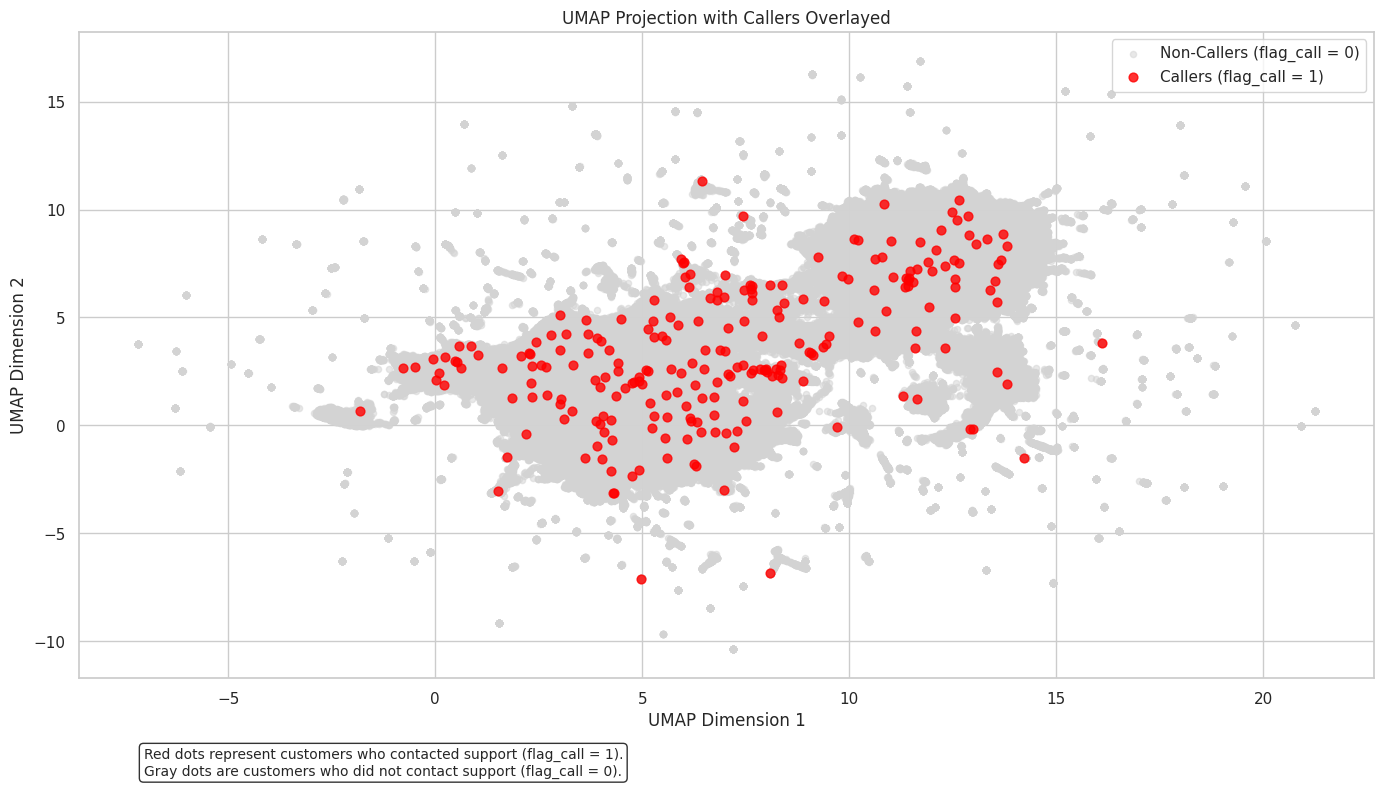

In [ ]:
# Create UMAP DataFrame
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['flag_call'] = y_full

# Split into non-callers and callers
df_non_callers = df_umap[df_umap['flag_call'] == 0]
df_callers = df_umap[df_umap['flag_call'] == 1]

# Plot
plt.figure(figsize=(14, 8))

# Plot background (non-callers)
plt.scatter(
    df_non_callers['UMAP1'], df_non_callers['UMAP2'],
    c='lightgray', label='Non-Callers (flag_call = 0)', s=20, alpha=0.5
)

# Overlay callers in red
plt.scatter(
    df_callers['UMAP1'], df_callers['UMAP2'],
    c='red', label='Callers (flag_call = 1)', s=40, alpha=0.8
)

# Title and axis
plt.title('UMAP Projection with Callers Overlayed')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()

# Explanation
plt.text(
    0.05, -0.15,
    'Red dots represent customers who contacted support (flag_call = 1).\n'
    'Gray dots are customers who did not contact support (flag_call = 0).',
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.8)
)

plt.grid(True)
plt.tight_layout()
plt.show()


Cluster the callers according to network behavior patterns using DBSCAN
- help uncovers behavioral subgroups among callers

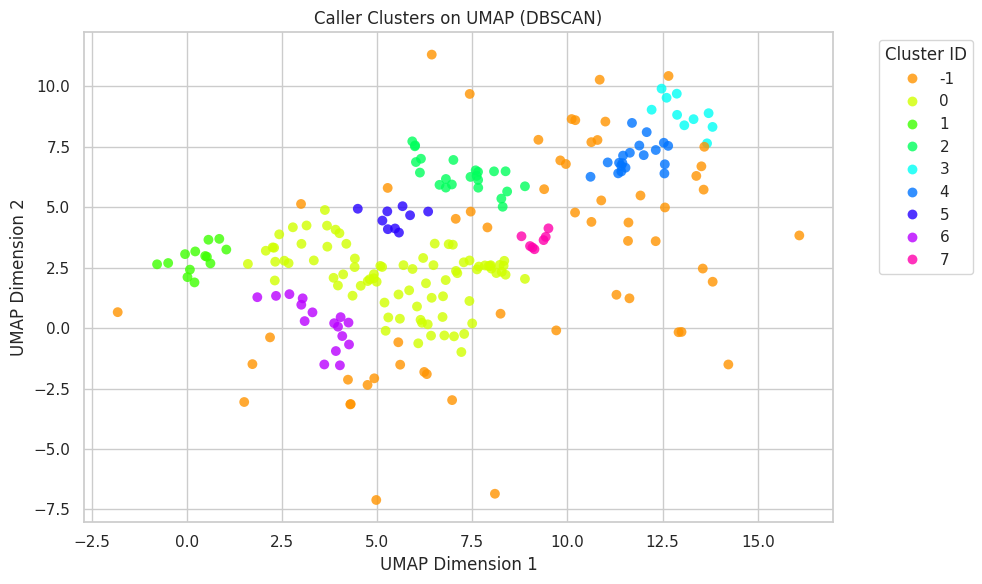

In [ ]:
# Create UMAP DataFrame
df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap['flag_call'] = y_full

# Filter only callers
df_callers = df_umap[df_umap['flag_call'] == 1].copy()
X_umap_callers = df_callers[['UMAP1', 'UMAP2']].values

# Apply DBSCAN clustering on caller UMAP coords
dbscan = DBSCAN(eps=0.8, min_samples=5)
cluster_labels = dbscan.fit_predict(X_umap_callers)
df_callers['cluster'] = cluster_labels

# Plot callers colored by cluster ID
plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", len(np.unique(cluster_labels)))
sns.scatterplot(
    data=df_callers, x='UMAP1', y='UMAP2',
    hue='cluster', palette=palette,
    style=None, s=50, alpha=0.8, edgecolor='none'
)

plt.title('Caller Clusters on UMAP (DBSCAN)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Attach cluster labels to original caller rows
df_clustered = df_tsfresh.loc[df_callers.index].copy()
df_clustered['cluster'] = df_callers['cluster'].values

# Compute feature summaries per cluster
# Exclude non-numeric columns
exclude_cols = ['device_id', 'analysis_date', 'flag_call', 'cluster']
numeric_cols = [col for col in df_clustered.columns if col not in exclude_cols]

# Mean per cluster
cluster_means = df_clustered.groupby('cluster')[numeric_cols].mean().T

# Show top differences
top_features = cluster_means.std(axis=1).sort_values(ascending=False).head(20).index
display(cluster_means.loc[top_features])

cluster,-1,0,1,2,3,4,5,6,7
congestion_ratio_24__variance,7.301051e+15,5.246441e-01,1.187345e+03,6.740211e-01,4.281536e-04,9.236175e-04,6.554835e-03,7.935453e-03,5.478500e-02
delta_poor_coverage_ratio_24__variance,3.542936e+15,1.183813e+13,3.384615e+12,3.140094e+12,6.022222e+12,4.338802e+15,6.925925e+13,2.820193e+00,2.209122e+01
poor_coverage_ratio_24__variance,6.508491e+14,3.777777e+12,1.128205e+12,2.173912e+12,2.000000e+12,1.446267e+15,2.649382e+13,9.879216e-01,9.426528e+00
delta_poor_coverage_ratio_total__variance,2.689683e+13,1.838135e+11,7.661074e-02,2.430676e+00,3.409390e+00,5.923281e-02,2.513151e-01,2.401068e-02,2.153965e+00
delta_poor_coverage_ratio_5__variance,1.796032e+13,3.593964e+11,7.689405e-03,6.736414e+00,3.244188e-01,3.068427e-01,6.614462e-02,8.003785e-03,2.922148e-02
poor_coverage_ratio_total__variance,1.244444e+13,2.825789e+11,3.827094e-03,8.454278e-01,1.296339e+00,3.671393e-02,3.068200e-02,1.118840e-02,1.801252e+00
poor_coverage_ratio_5__variance,7.194443e+12,3.429355e+11,4.885240e-03,2.253122e+00,1.060574e-01,2.726542e-01,3.364493e-02,5.177340e-03,2.859573e-02
congestion_ratio_5__variance,9.979453e-04,2.743476e+09,1.952041e-03,3.901777e-04,5.688049e-07,3.678601e-09,3.148310e-03,1.106176e-06,1.371093e-07
uptime_in_minutes__variance,5.444832e+07,9.761944e+07,8.647353e+06,1.189978e+09,1.319567e+06,1.439717e+06,1.238228e+06,9.690005e+07,1.719225e+06
free_memory__variance,4.134409e+06,1.976852e+07,4.402010e+06,4.580461e+07,9.815959e+05,5.195182e+07,1.667475e+05,4.260284e+06,6.106009e+05


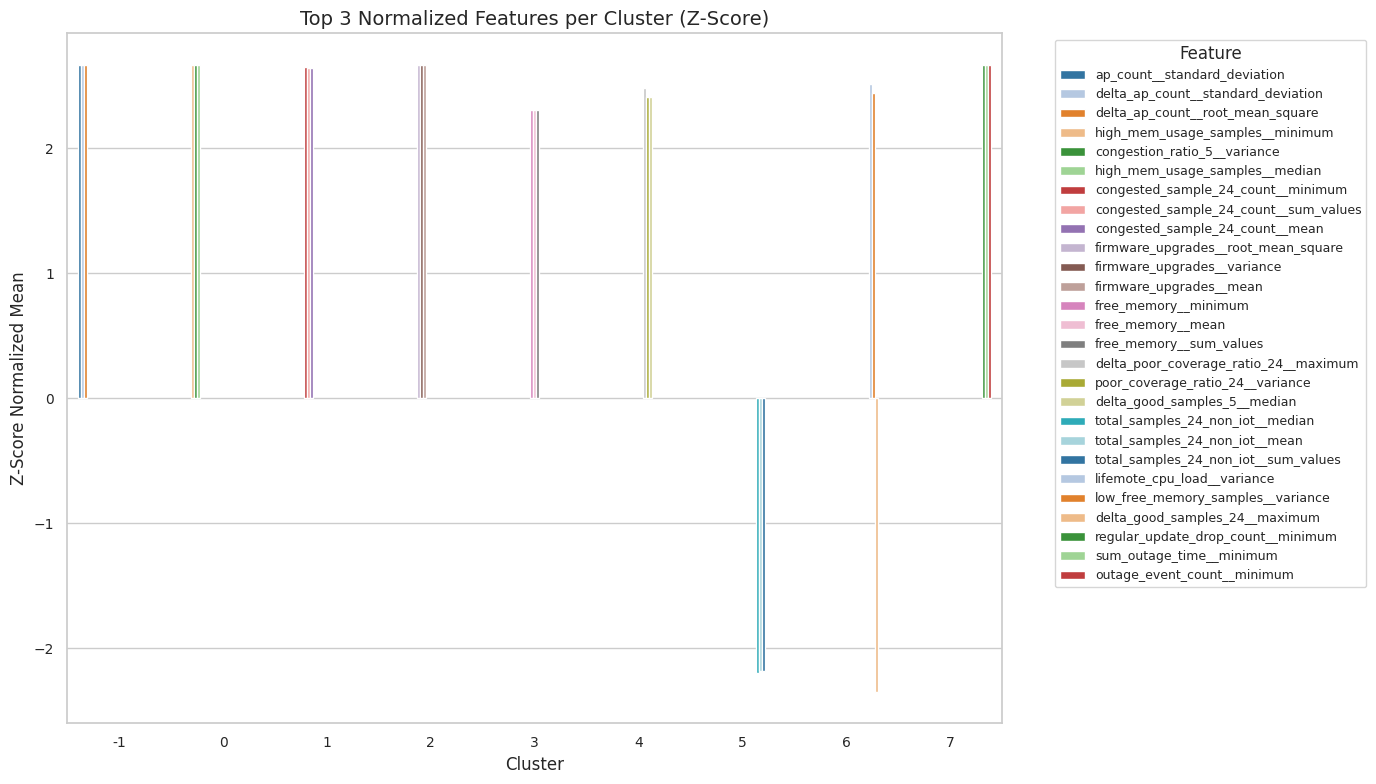

In [ ]:
# Normalize (Z-score row-wise)
cluster_means_normalized = cluster_means.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# Extract Top 3 Features per Cluster
plot_data = []
for cluster in cluster_means_normalized.columns:
    top_features = cluster_means_normalized[cluster].abs().sort_values(ascending=False).head(3).index
    for feature in top_features:
        value = cluster_means_normalized.loc[feature, cluster]
        plot_data.append({'Cluster': int(cluster), 'Feature': feature, 'ZScore': value})

df_plot = pd.DataFrame(plot_data)

# Sort Clusters Numerically
df_plot = df_plot.sort_values(by='Cluster')

# Plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
palette = sns.color_palette("tab20", n_colors=df_plot['Feature'].nunique())

bar = sns.barplot(
    data=df_plot,
    x='Cluster',
    y='ZScore',
    hue='Feature',
    palette=palette
)

plt.title('Top 3 Normalized Features per Cluster (Z-Score)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Z-Score Normalized Mean', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Feature', fontsize=9)
plt.tight_layout()
plt.show()


Positive Z-score = standard deviation of feature is higher than average

Negative Z-score = standard deviation of feature is lower than average

/tmp/ipython-input-1792610590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1792610590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1792610590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1792610590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1792610590.py:23: FutureWarning: 

Passin

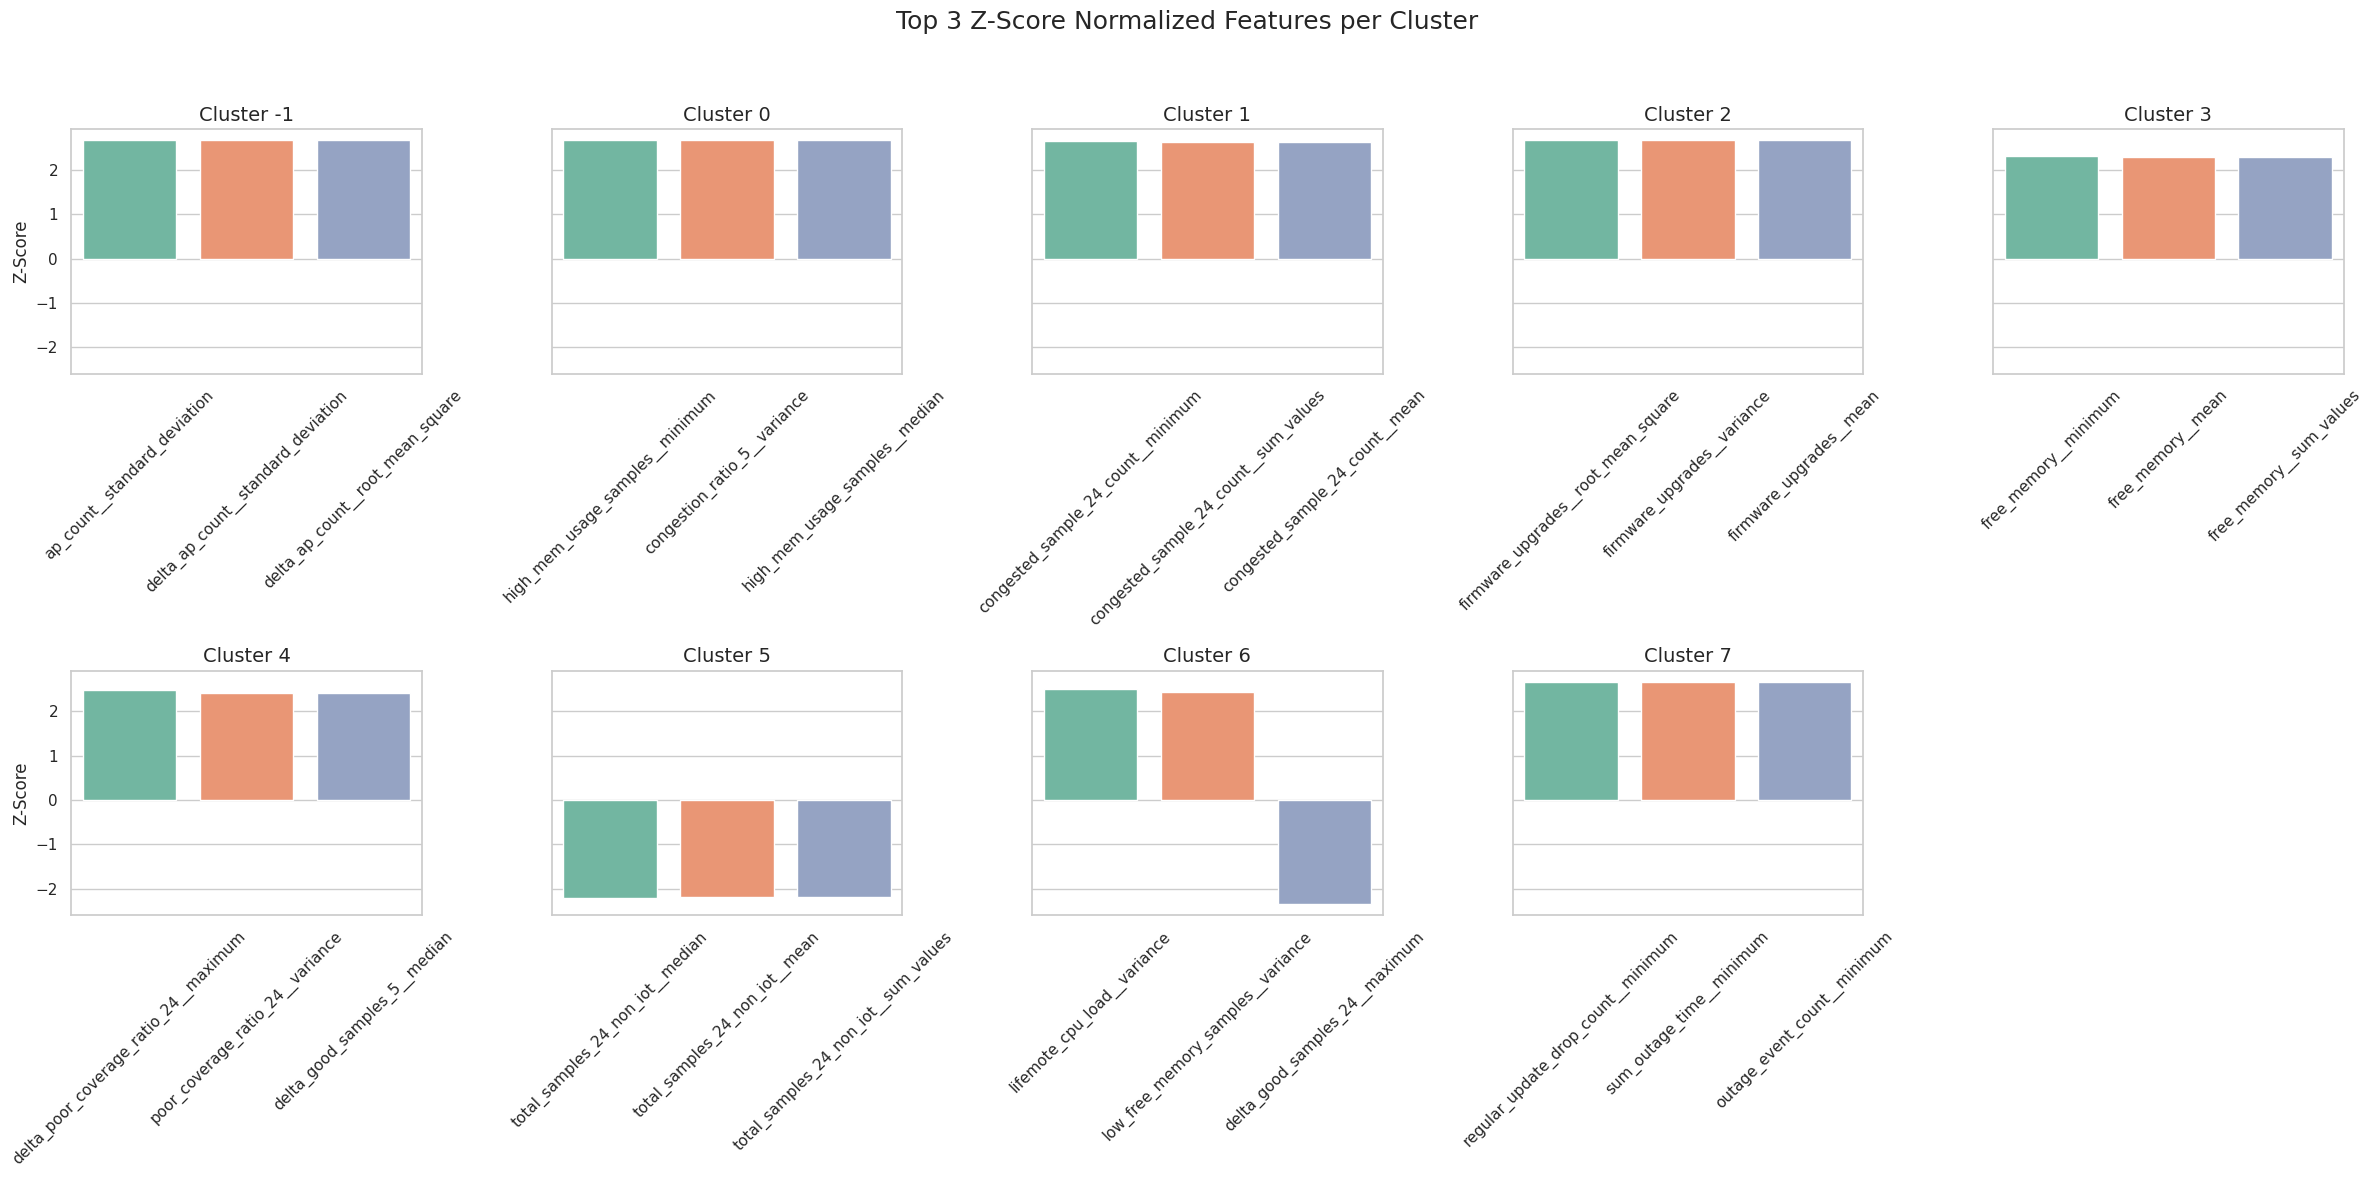

In [ ]:
# Extract top 3 features per cluster
top_features_per_cluster = {}
for cluster in cluster_means_normalized.columns:
    top3 = cluster_means_normalized[cluster].abs().sort_values(ascending=False).head(3).index
    top_features_per_cluster[cluster] = top3

# Create a subplot grid
num_clusters = len(top_features_per_cluster)
cols = 5
rows = (num_clusters + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(24, 12), sharey=True)
axes = axes.flatten()

# Plot each cluster's top 3 features
for i, (cluster, top_features) in enumerate(top_features_per_cluster.items()):
    values = cluster_means_normalized.loc[top_features, cluster]
    sns.barplot(
        x=values.index,
        y=values.values,
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f'Cluster {cluster}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45, labelsize=11)
    axes[i].tick_params(axis='y', labelsize=11)
    axes[i].set_xlabel('', fontsize=12)
    axes[i].set_ylabel('Z-Score', fontsize=12)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Enlarged main title
plt.suptitle('Top 3 Z-Score Normalized Features per Cluster', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
